## MSc Data Analytics - Capstone Project

#### Predictive Analysis in the Coffee Market: Using Deep Learning to predict coffee prices.
Student id: 2020274 Clarissa Cardoso


## Introduction
This notebook aims to analyse historical coffee price indices and develop a predictive model for future price trends in the green coffee market. The focus is on using data from the ICO (International Coffee Organization), particularly the composite prices indec (I-CIP), that combines prices of Colombian Milds, Other Milds, Brazilian Naturals, and Robustas.

### Dataset:
The dataset used in this analysis consists of historical coffee price data, with daily observations for business days. Prices are expressed in cents of USD per lb. and stated on a
differential basis to the New York and London futures exchanges (https://icocoffee.org/wp-content/uploads/2023/01/icc-105-17-r1e-rules-indicator-prices.pdf)

The data utilized in this project is sourced from the International Coffee Organization's (ICO) Public Market Information (https://ico.org/resources/public-market-information/), which provides the I-CIP values free of charge.

For the early stages of the experimentation, 1 year worth of data was available to collect, from 01Feb23 to 29Feb24, which is present on a separate notebook (2020274_capstone_EDA_Models 2.ipynb). In this notebook, recent data from March to September 2024 were added to expand insights and feed more datapoints to modelling stage. 


### Objectives:
1. Clean and preprocess the dataset for missing values and inconsistencies.
2. Explore the time-series behavior of coffee prices through visualizations.
3. Implement various forecasting models to predict future price trends, including traditional statistical models (e.g., ARIMA/Sarima) and deep learning algorithms (e.g., LSTM neural networks).
4. Compare model performance using key metrics (e.g., RMSE, MAE).


### Expected Outcome:
By the end of this notebook, we will identify the best forecasting model for coffee prices and present actionable insights based on the findings.

        Forecasting: generate forecasts for future I-CIP values using the best-performing model(s) and visualize the results to facilitate interpretation and decision-making.
- 1 day
- 5 days = 1 week
- 21 days = 1 month


(- 63 days = 3 months (1 quarter))

### Importing relevant libraries for the project

In [1]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #dataframes 
import numpy as np #linear algebra
import seaborn as sns #visualization
sns.set(color_codes=True)


import plotly.express as px
import plotly.graph_objects as go


import scipy.stats as stats #statistical resources

import matplotlib.pyplot as plt #visualisation 
%matplotlib inline 


from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl

from sklearn.model_selection import train_test_split # importing function to split the data training and test.
from sklearn.preprocessing import MinMaxScaler # Import the MinMaxScaler module from sklearn.preprocessing library
from sklearn.linear_model import LinearRegression # importing to performe linear regression. 
from sklearn.metrics import make_scorer, r2_score # Importing from Metrics module
from sklearn.preprocessing import StandardScaler # standardize the data
from sklearn import metrics # Metrics module from scikit-learn
from sklearn.model_selection import GridSearchCV # importing for hyperparameter tunning
from sklearn.metrics import mean_squared_error # importing mse
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #last update in python causing dead kernel wehn importing keras functions?
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.interpolate import interp1d

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


## cheking if keras/tensorflow are correclty installed 

Keras version: 2.10.0
TensorFlow version: 2.10.0


# 1. Load data

For the early stages of this experimentation present on the first notebook (Models2_copy), 1 year worth of data was available to collect, from 01Feb23 to 29Feb24.

This section will review the original dataset compiled with data from feb 23 to feb 24.


A few thingsobserved when importing the raw files from the data source: 

- Column mismatch: Assuming all files have the same column names and order. This could lead to errors when merging DataFrames with different structures. 

The data for each month is published separetely. Originally the 4 first months had different colum labels for the same data 'ICO Composite' , while the following months was simpler version as 'I-CIP'. For that diverson it was not possible to simply merge all dataframes into one. Dta cleaning/manipulation techniques of renamimbg and reorganising them chronologically were adopeted to reach the final dataset for the first year of data alocated in the 'icip_data' below. 





In [3]:
# Read the CSV file 
icip_data = pd.read_csv("icip_df.csv")

# View the first 5 rows
icip_data.head()

date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0  2023-02-01  171.43           235.92       223.22         191.65    102.31   
1  2023-02-02  172.50           237.34       226.26         192.86    102.00   
2  2023-02-03  169.47           232.24       221.86         188.61    101.52   
3  2023-02-06  171.29           235.17       224.80         190.77    102.02   
4  2023-02-07  172.14           235.65       226.72         191.92    102.10   

   year  month  
0  2023      2  
1  2023      2  
2  2023      2  
3  2023      2  
4  2023      2

In [4]:
icip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             279 non-null    object 
 1   I-CIP            279 non-null    float64
 2   colombian_milds  279 non-null    float64
 3   other_milds      279 non-null    float64
 4   brazilian_nat    279 non-null    float64
 5   robustas         279 non-null    float64
 6   year             279 non-null    int64  
 7   month            279 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 17.6+ KB


Since then, ICO has released additional months that will be included in the main dataframe, considering the timeframe from march to september 2024 as a way to feed more data to the models with the expectation it could improve the results. These seven new files will be sorted by chronological order and have the same labels as the main one above. 


### Importing  additional data from March/24 to September/24 

In [5]:
import os
# List all the files in the folder
os.listdir("icip_24") 

['I-CIP_September_2024.csv',
 'I-CIP_August_2024.csv',
 'I-CIP_April_2024.csv',
 'I-CIP_March_2024.csv',
 'I-CIP_May_2024.csv',
 'I-CIP_July_2024.csv',
 'I-CIP_June_2024.csv']

In [6]:
#create for loop to import csv files from the folder with less comands.

# create an empty list to store dfs
dataframes = []

# path to folder where csv files are (in this case same directory)
folder_path = "icip_24"


# to import CSV starting from the third row, skipping the first two
def import_csv(filepath):
    return pd.read_csv(filepath, skiprows=2)

# Iterate through files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # Only consider CSV files
        file_path = os.path.join(folder_path, file)  # Construct the full file path
        dataframes.append(import_csv(file_path))  # Read CSV and append to list

In [7]:
#check the lenght of the directory, how many files exist in the new folder
len(dataframes)

7

Chcking the heading of the files to undertand how features are allocated in this first stage before combining the new 7 months to main dataframe

The same issue appears with the heading names. So this time around it was decided to ignore the first 2 rows to avoid the unnamed labels and only import the actual data 

>Unnamed: 0	Unnamed: 1	Colombian	Unnamed: 3	Brazilian	Unnamed: 5


>0	NaN	I-CIP	NaN	Other Milds	NaN	Robusta


In [8]:
#check if order of files correspond with the directory list, testing if loop is working
dataframes[5].head()

Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0     01-Jul      224.77  248.87      245.94    227.53      202.00
1     02-Jul      228.21  251.41      249.08    232.47      204.63
2     03-Jul      225.51  248.18      245.85    228.99      203.10
3     04-Jul      227.04  247.42      246.27    228.97      207.38
4     05-Jul      230.76  251.20      252.03    234.53      208.30

In [9]:
print(dataframes)
#list of all dataframes

[   Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0      02-Sep      241.71  265.38      260.21    239.79      224.69
1      03-Sep      241.20  264.48      259.50    239.13      224.54
2      04-Sep      245.35  266.69      260.63    241.03      233.05
3      05-Sep      249.73  269.06      268.61    247.93      233.82
4      06-Sep      243.88  262.39      261.53    241.58      229.40
5      09-Sep      247.47  269.31      268.28    246.38      228.99
6      10-Sep      251.18  272.41      271.39    250.57      232.83
7      11-Sep      252.78  272.00      270.98    250.20      237.98
8      12-Sep      255.22  273.63      273.58    252.47      240.75
9      13-Sep      265.67  283.72      283.53    262.78      251.73
10     16-Sep      264.57  282.28      282.63    261.62      250.68
11     17-Sep      269.45  288.40      288.74    267.76      253.35
12     18-Sep      269.47  288.21      288.56    267.49      253.80
13     19-Sep      265.09  283.29      284.33  

To continue the project is necessary to make 2 adjustments in the second directory:
- change the date format from " 06-Jun" to '%Y-%m-%d' format and apply this to all files in the "Unnamed: 0" collum which corresponds to date. This will enable a more smooth combination of the 2 dfs once all dates mantain the correct format. 

In [10]:
# Test: print the first DataFrame to check if the transformation worked
print(dataframes[5].head())

  Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0     01-Jul      224.77  248.87      245.94    227.53      202.00
1     02-Jul      228.21  251.41      249.08    232.47      204.63
2     03-Jul      225.51  248.18      245.85    228.99      203.10
3     04-Jul      227.04  247.42      246.27    228.97      207.38
4     05-Jul      230.76  251.20      252.03    234.53      208.30


The code below will use the month mapping to rearranje data in the first colum from corresponding to dates.
- first it will change the format from '**01-Jul**' to **''%Y-%m-%d''** through all months in the list of dataframes.
- then will replace the dataframes with the correct format and set as 'datetime' type. 
- print the correct year for all dataframes and show the correct label for 'date'

In [11]:
# Function to transform the 'Unnamed: 0' date column for each DataFrame in the list and reorder columns
def transform_date(dataframes, year):
    month_mapping = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    
    # Iterate over each DataFrame in the list
    for i in range(len(dataframes)):
        df = dataframes[i]
        
        # Print the columns to inspect if 'Unnamed: 0' exists or if the name is different
        print(f"Columns in DataFrame {i}: {df.columns}")
        
        # Check if 'Unnamed: 0' exists, otherwise handle the column name differently
        if 'Unnamed: 0' in df.columns:
            # Apply the transformation to the 'Unnamed: 0' column to create full date strings
            df['date'] = df['Unnamed: 0'].apply(
                lambda x: '-'.join([str(year), month_mapping[x.split('-')[1]], x.split('-')[0]])
            )
            
            # Convert the 'Date' column to datetime format
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
            
            # Drop the original 'Unnamed: 0' column
            df.drop(columns=['Unnamed: 0'], inplace=True)
            
            # Reorder columns to place 'Date' first
            columns = ['date'] + [col for col in df.columns if col != 'date']
            dataframes[i] = df[columns]  # Replace the DataFrame with the reordered one
        else:
            print(f"'Unnamed: 0' column not found in DataFrame {i}")
    
    return dataframes

# Apply the function to the list of DataFrames
dataframes = transform_date(dataframes, 2024)

# Test: print the first DataFrame to check if the column reordering worked
print(dataframes[0].head())

Columns in DataFrame 0: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 1: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 2: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 3: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 4: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 5: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 6: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
        date  Unnamed: 1   Milds  

## Splitting the date column to match main dataset

This function is mainly to add the last 2 columns matching the original dataset which contains the year and m,onth of each date. This can also be used for some of exploratory plots in next sectiosn. 

In [12]:
# Function to add year and month columns to each DataFrame in the list
def add_year_month_columns(dataframes):
    for i in range(len(dataframes)):
        df = dataframes[i]
        
        # Extract the year and month from the 'Date' column
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        
        # Replace the DataFrame in the list with the new columns added
        dataframes[i] = df
        
    return dataframes

# Apply the function to the list of DataFrames
dataframes = add_year_month_columns(dataframes)

# checking if transformation worked in the dataframes list:
dataframes[0].head()

date  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5  year  \
0 2024-09-02      241.71  265.38      260.21    239.79      224.69  2024   
1 2024-09-03      241.20  264.48      259.50    239.13      224.54  2024   
2 2024-09-04      245.35  266.69      260.63    241.03      233.05  2024   
3 2024-09-05      249.73  269.06      268.61    247.93      233.82  2024   
4 2024-09-06      243.88  262.39      261.53    241.58      229.40  2024   

   month  
0      9  
1      9  
2      9  
3      9  
4      9

### Define chronologic order for dataframe

In [13]:
# Define the list of DataFrames in the desired order
dfs_in_order = [dataframes[3],dataframes[2],dataframes[4],dataframes[6],dataframes[5],dataframes[1],dataframes[0]]

# Concatenate the DataFrames
merged_df = pd.concat(dfs_in_order,ignore_index=True)

# Display the merged DataFrame
merged_df

date  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5  year  \
0   2024-03-01      181.39  206.30      204.99    183.44      157.54  2024   
1   2024-03-04      183.10  209.76      207.30    185.63      157.91  2024   
2   2024-03-05      181.97  206.67      205.81    183.35      158.63  2024   
3   2024-03-06      185.77  209.44      208.59    186.12      164.27  2024   
4   2024-03-07      190.75  215.48      214.71    192.05      167.42  2024   
..         ...         ...     ...         ...       ...         ...   ...   
147 2024-09-24      269.83  289.78      291.26    267.94      252.30  2024   
148 2024-09-25      270.09  291.55      293.03    270.32      249.36  2024   
149 2024-09-26      272.70  296.96      296.29    274.52      249.30  2024   
150 2024-09-27      268.97  292.23      291.25    269.86      247.45  2024   
151 2024-09-30      270.37  294.02      292.80    271.99      248.00  2024   

     month  
0        3  
1        3  
2        3  
3        3  
4        3  
..     ...  
147      9  
148      9  
149      9  
150      9  
151      9  

[152 rows x 8 columns]

In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        152 non-null    datetime64[ns]
 1   Unnamed: 1  152 non-null    float64       
 2   Milds       152 non-null    float64       
 3   Unnamed: 3  152 non-null    float64       
 4   Naturals    152 non-null    float64       
 5   Unnamed: 5  152 non-null    float64       
 6   year        152 non-null    int64         
 7   month       152 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 9.6 KB


from the info function displays the new data contains 152 observations across 8 columss from march 24 to september 24.
the first colum shows dates in datetime format, followed by each category of coffee as well as the index values as floats. the added year and month number of each observation is in integer format.


### Rename column names prior to merging both datasets

This will enable to combine previous data from original dataset to have a bigger pool of observations to feed more data in the modeling part. Is expected the final dataset to combine data from feb/23 to sep/24

- df1 = icip_data > contains the original dataset (Feb 2023 - Feb 2024)
- df2 = merged_df > contains the new dataset (Mar 2024 - Sep 2024)



In [15]:
df1 = icip_data
df2 = merged_df


In [16]:
df1

date   I-CIP  colombian_milds  other_milds  brazilian_nat  \
0    2023-02-01  171.43           235.92       223.22         191.65   
1    2023-02-02  172.50           237.34       226.26         192.86   
2    2023-02-03  169.47           232.24       221.86         188.61   
3    2023-02-06  171.29           235.17       224.80         190.77   
4    2023-02-07  172.14           235.65       226.72         191.92   
..          ...     ...              ...          ...            ...   
274  2024-02-23  177.80           204.48       202.46         183.74   
275  2024-02-26  177.48           204.12       202.11         183.48   
276  2024-02-27  180.23           207.11       205.10         186.34   
277  2024-02-28  179.12           206.01       204.00         185.39   
278  2024-02-29  180.11           207.67       205.52         186.73   

     robustas  year  month  
0      102.31  2023      2  
1      102.00  2023      2  
2      101.52  2023      2  
3      102.02  2023      2  
4      102.10  2023      2  
..        ...   ...    ...  
274    149.40  2024      2  
275    149.08  2024      2  
276    151.51  2024      2  
277    150.23  2024      2  
278    150.40  2024      2  

[279 rows x 8 columns]

In [17]:
# Ensure that the 'Date' column in both df1 and df2 is in datetime format
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# Rename the columns in df2 to match the structure of df1
df2.columns = ['date', 'I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas', 'year', 'month']

# Concatenate df1 and df2 into a single DataFrame
combined_df = pd.concat([df1, df2], ignore_index=True)

# Sort by the 'Date' column to ensure chronological order
combined_df = combined_df.sort_values(by='date').reset_index(drop=True)

# Optionally, save the final DataFrame to a CSV file
#combined_df.to_csv('final_combined_data.csv', index=False)

# Test: print the first few rows to verify the result
print(combined_df.head())

        date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0 2023-02-01  171.43           235.92       223.22         191.65    102.31   
1 2023-02-02  172.50           237.34       226.26         192.86    102.00   
2 2023-02-03  169.47           232.24       221.86         188.61    101.52   
3 2023-02-06  171.29           235.17       224.80         190.77    102.02   
4 2023-02-07  172.14           235.65       226.72         191.92    102.10   

   year  month  
0  2023      2  
1  2023      2  
2  2023      2  
3  2023      2  
4  2023      2  


In [18]:
combined_df

date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0   2023-02-01  171.43           235.92       223.22         191.65    102.31   
1   2023-02-02  172.50           237.34       226.26         192.86    102.00   
2   2023-02-03  169.47           232.24       221.86         188.61    101.52   
3   2023-02-06  171.29           235.17       224.80         190.77    102.02   
4   2023-02-07  172.14           235.65       226.72         191.92    102.10   
..         ...     ...              ...          ...            ...       ...   
426 2024-09-24  269.83           289.78       291.26         267.94    252.30   
427 2024-09-25  270.09           291.55       293.03         270.32    249.36   
428 2024-09-26  272.70           296.96       296.29         274.52    249.30   
429 2024-09-27  268.97           292.23       291.25         269.86    247.45   
430 2024-09-30  270.37           294.02       292.80         271.99    248.00   

     year  month  
0    2023      2  
1    2023      2  
2    2023      2  
3    2023      2  
4    2023      2  
..    ...    ...  
426  2024      9  
427  2024      9  
428  2024      9  
429  2024      9  
430  2024      9  

[431 rows x 8 columns]

The combined dataset on the correct stucture can help to make better explorations on the next sections. 

# 2. Exploratory Data Analysis


This section aims to see how the data is presented, such as basic statistics and its distribution over time.  They can help to identify average levels, variability, and the range of values 
(large deviations might suggest volatility, which could be important for modeling in later stages of experimentation)


### 2.1 Summary statistics and checking for missing values

From the *info* fucntion we get 431 rows of numerical data, with the first colum showing values in datetime type followed by the ICO composite prices and each category of coffee used for the index. The last 2 columsn are the ones added earlier with the month and year of each data point. 

This analysis will help to interpret basic price dynamics before diving into more complex forecasting techniques, such as SaARIMA and LSTMs



In [19]:
#basic info

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             431 non-null    datetime64[ns]
 1   I-CIP            431 non-null    float64       
 2   colombian_milds  431 non-null    float64       
 3   other_milds      431 non-null    float64       
 4   brazilian_nat    431 non-null    float64       
 5   robustas         431 non-null    float64       
 6   year             431 non-null    int64         
 7   month            431 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 27.1 KB


In [20]:
# Summary Statistics for numeric columns 
combined_df.describe()

I-CIP  colombian_milds  other_milds  brazilian_nat    robustas  \
count  431.000000       431.000000   431.000000     431.000000  431.000000   
mean   187.857285       222.166218   220.083712     193.324548  152.914269   
std     31.780462        27.809617    27.193786      30.685967   41.248259   
min    145.990000       178.820000   174.970000     147.660000  101.520000   
25%    163.515000       197.635000   198.805000     170.085000  121.800000   
50%    177.480000       220.390000   216.090000     187.210000  134.210000   
75%    214.190000       243.220000   239.560000     216.060000  190.000000   
max    272.700000       296.960000   296.290000     274.520000  253.800000   

              year       month  
count   431.000000  431.000000  
mean   2023.452436    6.083527  
std       0.498311    3.050350  
min    2023.000000    1.000000  
25%    2023.000000    4.000000  
50%    2023.000000    6.000000  
75%    2024.000000    8.000000  
max    2024.000000   12.000000

In [21]:
# check missing values
print(combined_df.isnull().sum())

date               0
I-CIP              0
colombian_milds    0
other_milds        0
brazilian_nat      0
robustas           0
year               0
month              0
dtype: int64


In [22]:
# check missing values

print(combined_df.isna().sum())

date               0
I-CIP              0
colombian_milds    0
other_milds        0
brazilian_nat      0
robustas           0
year               0
month              0
dtype: int64


## 2.2 Trends over time 

### Plotting trends overtime to begin understanding how this new dataset is presented

This also helps in highlighting any major shifts or trends which are quite pronounced in this dataset. 


### a. Comparing the different categories over time:

Each category has a different weight to calculate the final composite. **(get data on this)**


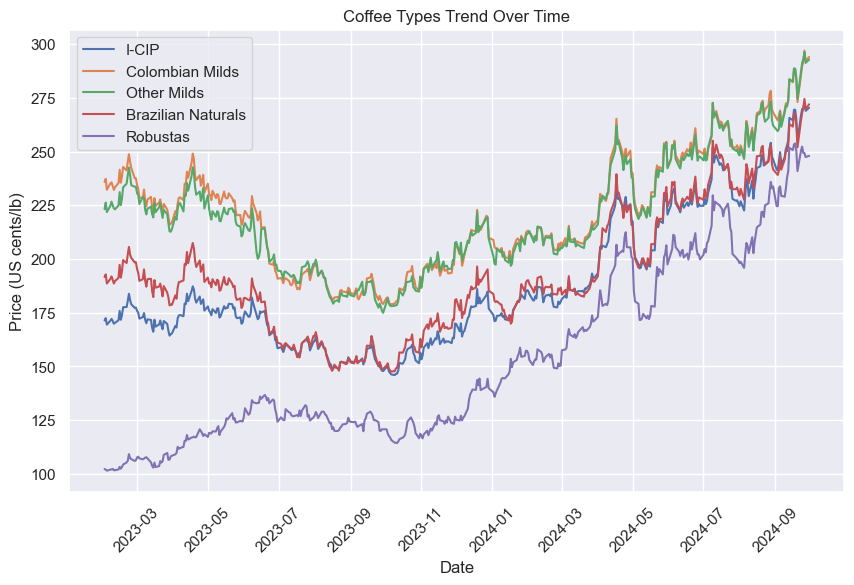

In [23]:
# Plot other categories of coffee over time
plt.figure(figsize=(10, 6))
plt.plot(combined_df['date'], combined_df['I-CIP'], label='I-CIP')
plt.plot(combined_df['date'], combined_df['colombian_milds'], label='Colombian Milds')
plt.plot(combined_df['date'], combined_df['other_milds'], label='Other Milds')
plt.plot(combined_df['date'], combined_df['brazilian_nat'], label='Brazilian Naturals')
plt.plot(combined_df['date'], combined_df['robustas'], label='Robustas')
plt.xlabel('Date')
plt.ylabel('Price (US cents/lb)')
plt.title('Coffee Types Trend Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()


changing labels for date axis for easier visualisation (ie from 2023-03 to MAR 2023)

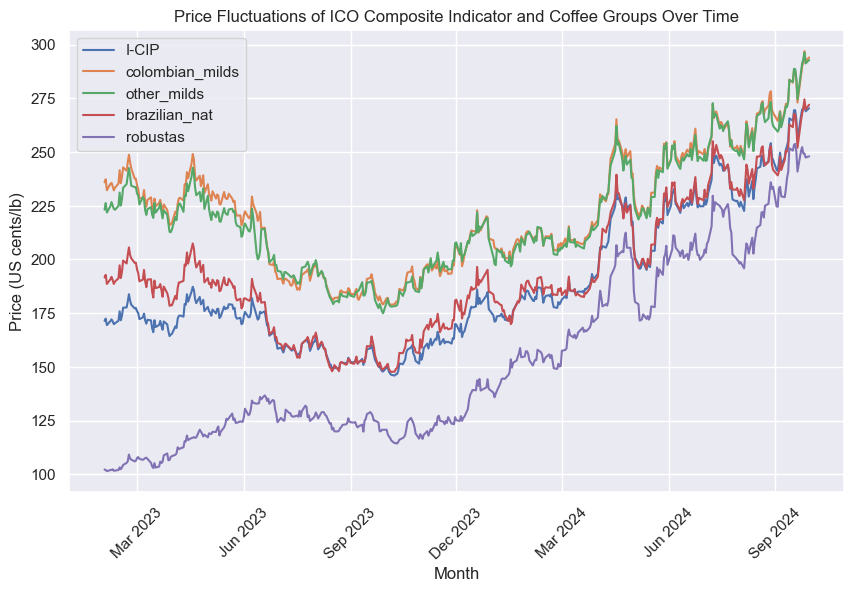

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define only the columns you want to plot (excluding the last two columns)
columns_to_plot = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']

plt.figure(figsize=(10, 6))

# Iterate over the selected columns and plot each one
for column in columns_to_plot:
    plt.plot(combined_df['date'], combined_df[column], label=column)

# Customize x-axis to show months (use date format for better readability)
plt.xlabel('Month')
plt.ylabel('Price (US cents/lb)')
plt.title('Price Fluctuations of ICO Composite Indicator and Coffee Groups Over Time')
plt.legend()

# Format the x-axis labels to show the month name with better spacing
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Shows every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Rotate for better readability

# Show plot
plt.show()

A few things to consider fgrom this main plot:


The plot above illustrates the price fluctuations of the ICO Composite Indicator (I-CIP) and four key coffee categories—Colombian Milds, Other Milds, Brazilian Naturals, and Robustas—over a period from Febuary 2023 to September 2024. 

all categories exhibit a general upward trend, reflecting an overall increase in coffee prices. 

Colombian Milds consistently maintains the highest price, followed by Other Milds, with Brazilian Naturals and Robustas being comparatively lower in price.

The I-CIP line in blue serves as a composite indicator, providing an average of these categories. Notable price peaks appear around March 2023 and mid-2024, suggesting potential seasonal or market-related impacts on prices. Toward the end of the timeline, there is a significant price surge across all categories, which may be attributed to factors such as supply chain disruptions or increased global demand.



###  Setting the date column as index:


In [25]:
#create new variable for merged_df and reseting date as the index for building time series in later stages
# Set 'date' column as index
combined_df.set_index('date', inplace=True)

#check output
icip_df = combined_df
icip_df.head()

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-02-01  171.43           235.92       223.22         191.65    102.31   
2023-02-02  172.50           237.34       226.26         192.86    102.00   
2023-02-03  169.47           232.24       221.86         188.61    101.52   
2023-02-06  171.29           235.17       224.80         190.77    102.02   
2023-02-07  172.14           235.65       226.72         191.92    102.10   

            year  month  
date                     
2023-02-01  2023      2  
2023-02-02  2023      2  
2023-02-03  2023      2  
2023-02-06  2023      2  
2023-02-07  2023      2

In [26]:
icip_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 2023-02-01 to 2024-09-30
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I-CIP            431 non-null    float64
 1   colombian_milds  431 non-null    float64
 2   other_milds      431 non-null    float64
 3   brazilian_nat    431 non-null    float64
 4   robustas         431 non-null    float64
 5   year             431 non-null    int64  
 6   month            431 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 26.9 KB


###  b. Checking the range of dataset: 


With the dates as indext we can check the range of the dataset: 

- 607 days however the data collected is at a frequency of BUSINESS DAYS, excluding weekends and holidays, which would account for the difference between the total days (607) and the number of observations (431).

In [27]:
## Checking how many days are present in the dataset

print(f'Dataframe contains prices between {icip_df.index.min()} {icip_df.index.max()}')
print(f'Total Days = {icip_df.index.max() - icip_df.index.min()} days')

Dataframe contains prices between 2023-02-01 00:00:00 2024-09-30 00:00:00
Total Days = 607 days 00:00:00 days


### Once the date is set as index, is possible to measure the range an frequency of data. 




In [28]:
# making sure the index is set at datetime 
icip_df.index = pd.to_datetime(icip_df.index)

In [29]:
### From the range, confirm the frequency of the index
print(icip_df.index.freq)

None


A freq marked as 'None' makes python treat the date as irregular. Manually setting the frquency as Business days since the frequancy is not really defined.
This can have a series of benefits:
- Align  data with time-based operations.
- Perform accurate rolling calculations and time series decomposition.
- Handle missing data systematically.
- Use advanced time series models and resampling.


https://pandas.pydata.org/pandas-docs/version/0.16/timeseries.html

In [30]:
icip_df = icip_df.asfreq('B')  # B stands for Business Days

In [31]:
### From the range, confirm the frequency of the index
print(icip_df.index.freq)

<BusinessDay>


In [32]:
icip_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2023-02-01 to 2024-09-30
Freq: B
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I-CIP            431 non-null    float64
 1   colombian_milds  431 non-null    float64
 2   other_milds      431 non-null    float64
 3   brazilian_nat    431 non-null    float64
 4   robustas         431 non-null    float64
 5   year             431 non-null    float64
 6   month            431 non-null    float64
dtypes: float64(7)
memory usage: 27.1 KB


After setting the freqeuncy as busines days, the index automatically added 3 more empty rows to the dataset.
index shows **434** entries while non null count is **431**. That means data imputation is required (which will be addressed in further sections for data preparation)


### c. Value distribution across categories

In [33]:
# Define colors from the Set2 palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

# Specify the columns you want to include in the boxplot
selected_columns = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']  

# Create boxplot traces
box_traces = []
for i, column in enumerate(selected_columns):
    color = colors[i % len(colors)] 
    box_trace = go.Box(y=icip_df[column], name=column, marker=dict(color=color))
    box_traces.append(box_trace)

# Create layout
layout = go.Layout(title='Boxplot by Column', yaxis=dict(title='Value'), xaxis=dict(title='Variable'))

# Create figure
fig = go.Figure(data=box_traces, layout=layout)

# Show plot
fig.show()

## d. Mean values of each category


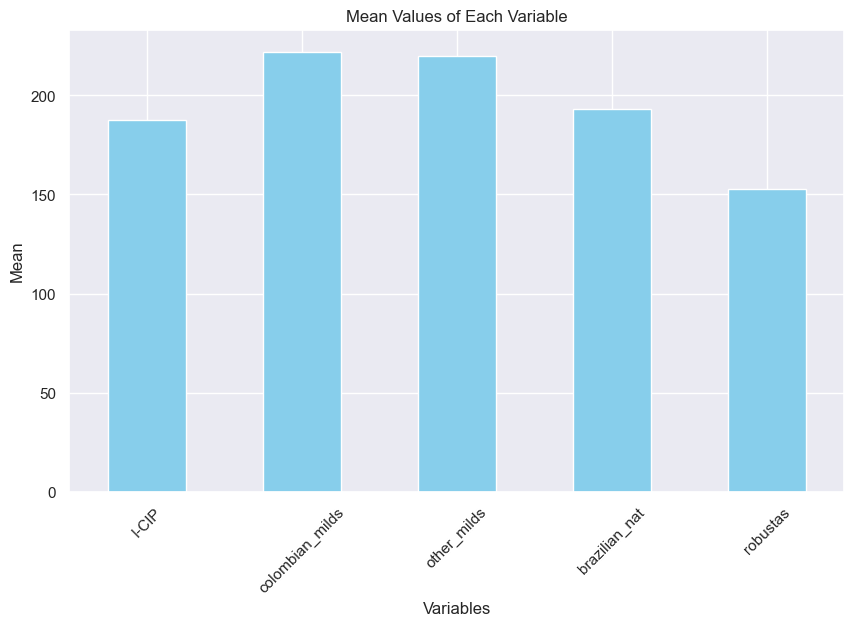

In [34]:

# Bar plot of mean values for each column
plt.figure(figsize=(10, 6))
icip_df[selected_columns].mean().plot(kind='bar', color='skyblue')
plt.title('Mean Values of Each Variable')
plt.xlabel('Variables')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()

## e.  Correlation Matrix for Coffee Prices

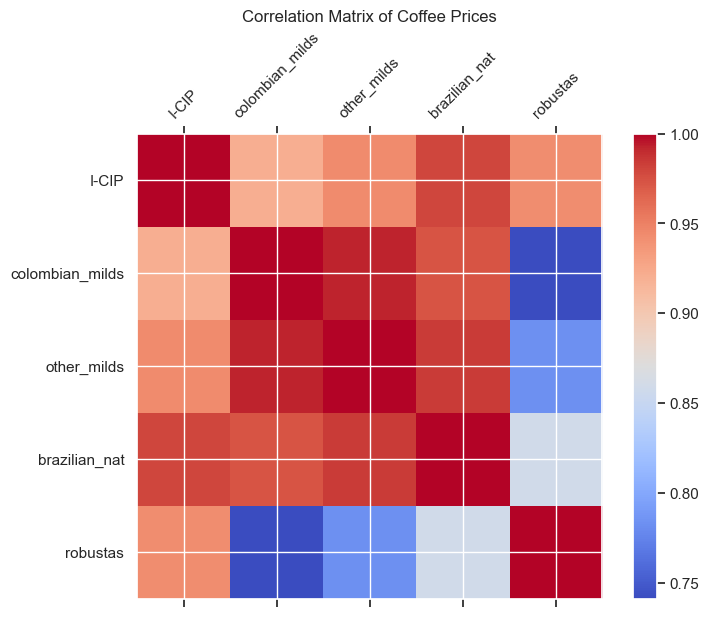

In [35]:
# Correlation Matrix for Coffee Prices
correlation_matrix = icip_df[['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']].corr()

plt.figure(figsize=(8, 6))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title("Correlation Matrix of Coffee Prices")
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

###### plot monthy only by category 

>>The matrix highlights that colombian_milds and other_milds are closely related and likely to be primary influencers on the I-CIP index. In contrast, robustas exhibits more independence from other types. These relationships provide a foundation for selecting variables in a forecasting model, where incorporating highly correlated categories might improve predictive accuracy.<<



###  2.2.1 ICO Composite Indicator Price (I-CIP) 

I-CIP is the main feature to be used for this analysis. 
 
 
There’s a clear upward trend in the I-CIP index from early 2023 to late 2024. This suggests that coffee prices, as represented by I-CIP, have generally increased over this period.

Initial Fluctuations (Early to Mid-2023): In the first part of the timeline (early to mid-2023), the I-CIP prices exhibit noticeable fluctuations, with a few peaks and troughs. This suggests some instability in the market, with prices rising and falling frequently.

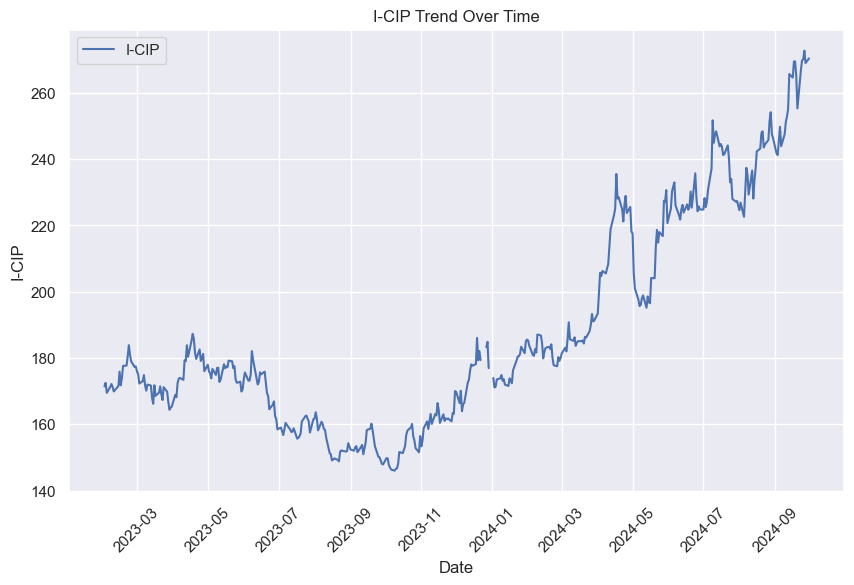

In [36]:
import matplotlib.pyplot as plt

# Plot I-CIP over time
plt.figure(figsize=(10, 6))
plt.plot(icip_df['I-CIP'], label='I-CIP')
plt.xlabel('Date')
plt.ylabel('I-CIP')
plt.title('I-CIP Trend Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

looking closer at the gap in thi line plot:
between dec 23 and jan 24 there seems to have a missing value there


### 2.2.1

### a. Checking monthly seasonality

This plot shows the seasonalityvariation in the composite prices over the years 

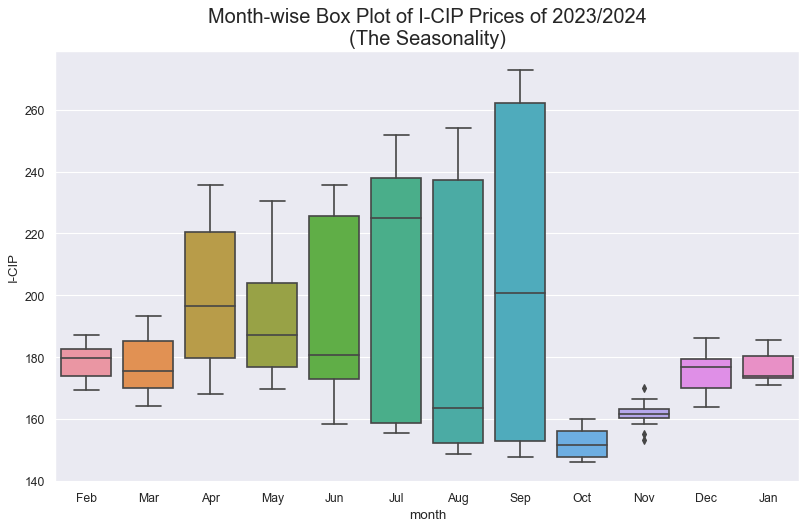

In [53]:
# Extract year and month from the index

## plot only for 2023 and plot a separate for 2024
#are variations in price the same in both year????




icip_df['year'] = icip_df.index.year
icip_df['month'] = icip_df.index.month_name().str[:3]  # This will give  the three-letter month abbreviation.

# Draw Plot
plt.figure(figsize=(12, 7), dpi=80)
sns.boxplot(x='month', y='I-CIP', data=icip_df)

# Set Title
plt.title('Month-wise Box Plot of I-CIP Prices of 2023/2024\n(The Seasonality)', fontsize=18)

# Show the plot
plt.show()

In [54]:
icip_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2023-02-01 to 2024-09-30
Freq: B
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I-CIP            431 non-null    float64
 1   colombian_milds  431 non-null    float64
 2   other_milds      431 non-null    float64
 3   brazilian_nat    431 non-null    float64
 4   robustas         431 non-null    float64
 5   year             434 non-null    int64  
 6   month            434 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 43.3+ KB


##  b. Separating values montly per each year

Re-arranging the order for yearly plots since the data is not complete, since we have for 2023: Feb to Dec and 2024: Jan to Sep, the labels are done manually below

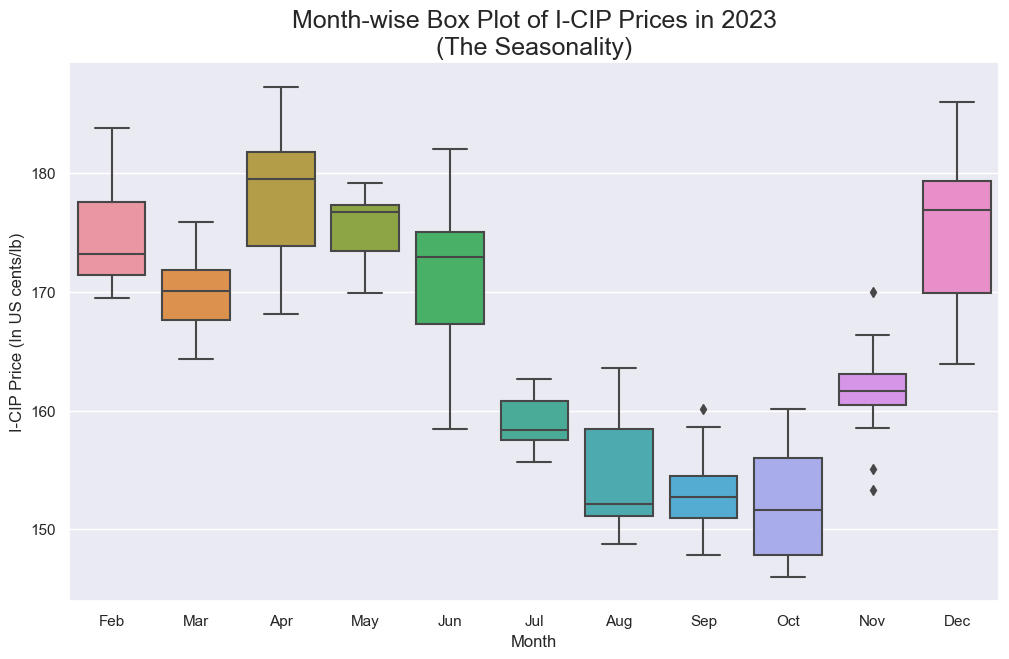

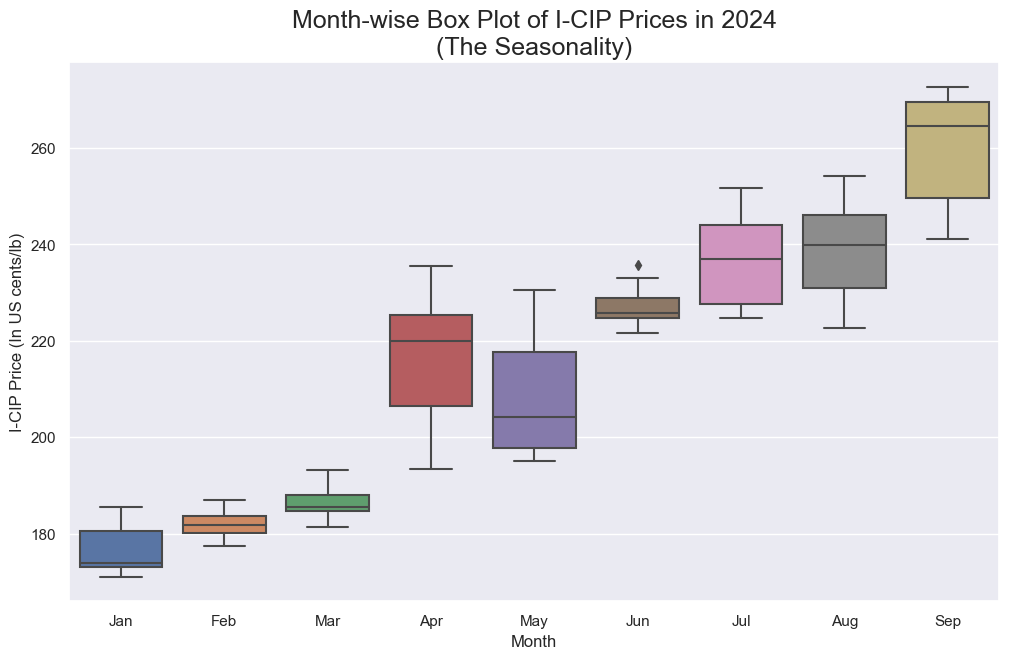

In [55]:
# Filter data by year
df_2023 = icip_df[icip_df['year'] == 2023]
df_2024 = icip_df[icip_df['year'] == 2024]

# Plot for 2023
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_2023, order=['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2023\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

# Plot for 2024 (up to September)
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_2024, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2024\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

## 2.3 Data Cleaning: Checking for Missing Dates 

for determine the right frequency


 The output of the first code below shows exacly how many days contains in the dataset, based on the indexes. while the second one will say how many of those total days are actually the business days containing data for the analisis 


In [37]:
## Checking how many days are present in the dataset

print(f'Dataframe contains prices between {icip_df.index.min()} {icip_df.index.max()}')
print(f'Total Days = {icip_df.index.max() - icip_df.index.min()} days')

Dataframe contains prices between 2023-02-01 00:00:00 2024-09-30 00:00:00
Total Days = 607 days 00:00:00 days


In [38]:
# Generate a date range for 366 days from the start of the data

start_date = icip_df.index.min()
end_date = icip_df.index.max()  


# Generate a range of business days within this period
business_days = pd.bdate_range(start=start_date, end=end_date)

# Now compare the business_days with icip_df index to find out missing dates
missing_dates = business_days.difference(icip_df.index)

print(f"Total number of expected business days: {len(business_days)}")
print(f"Total number of actual days in data: {icip_df.shape[0]}")
print(f"Total number of missing dates: {len(missing_dates)}")
print("Missing dates are:")
print(missing_dates)

Total number of expected business days: 434
Total number of actual days in data: 434
Total number of missing dates: 0
Missing dates are:
DatetimeIndex([], dtype='datetime64[ns]', freq='B')


The code above says there are no missing dates in the dataframe, however, it still shows there are a few NaN values. This is confirmed below with the *is null* code that shows a total of 3 missing values across all columns:  out of the 434 entries computed by the datetime index, ranging from 2023-02-01 to 2024-09-30

In [39]:
# Sum of Nan values
#icip_df.info()
print(icip_df.shape)
print(icip_df.isnull().sum())


(434, 7)
I-CIP              3
colombian_milds    3
other_milds        3
brazilian_nat      3
robustas           3
year               3
month              3
dtype: int64


**These different methods all confirm there are missing values present in the combined dataset**

In [40]:
# if there is any missing values will come back TRUE
icip_df.isnull().values.any()

True

Booleans will say True for any missing valies

In [41]:
nan_df = icip_df.isna()
print(nan_df)

            I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                       
2023-02-01  False            False        False          False     False   
2023-02-02  False            False        False          False     False   
2023-02-03  False            False        False          False     False   
2023-02-06  False            False        False          False     False   
2023-02-07  False            False        False          False     False   
...           ...              ...          ...            ...       ...   
2024-09-24  False            False        False          False     False   
2024-09-25  False            False        False          False     False   
2024-09-26  False            False        False          False     False   
2024-09-27  False            False        False          False     False   
2024-09-30  False            False        False          False     False   

           

Separate dataframe isolating the dates with True/False booleans 

In [42]:
nan_rows = icip_df.isna().any(axis=1)
print(nan_rows)

date
2023-02-01    False
2023-02-02    False
2023-02-03    False
2023-02-06    False
2023-02-07    False
              ...  
2024-09-24    False
2024-09-25    False
2024-09-26    False
2024-09-27    False
2024-09-30    False
Freq: B, Length: 434, dtype: bool


In [43]:
#filter rows with nan values
nan_rows = icip_df[icip_df.isna().any(axis=1)]

**Plot figure to highlight missing values**

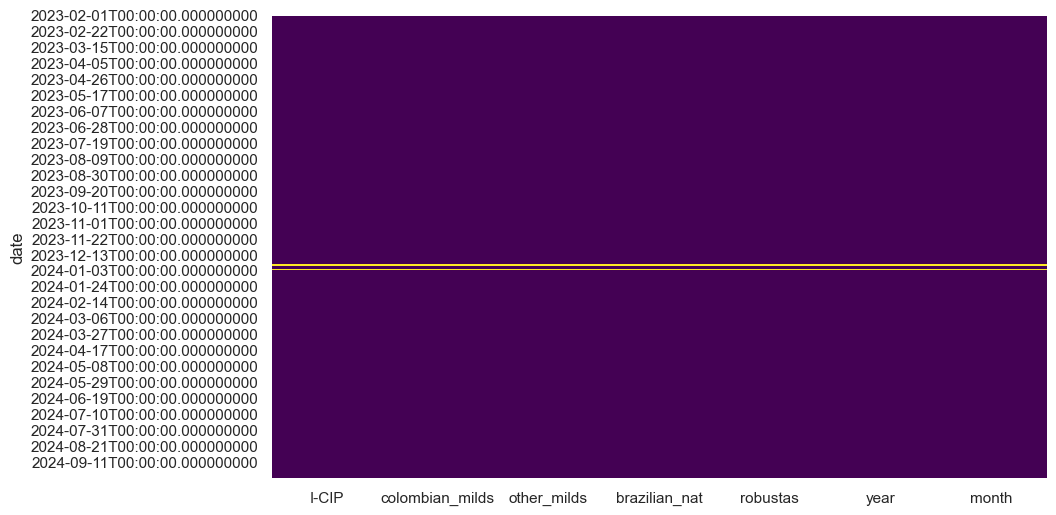

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(icip_df.isna(), cbar=False, cmap="viridis")
plt.show()

**EXTRACT MISSING DATES FROM THE INDEX**


In [45]:
# Display the dates with missing data
nan_rows.index

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01'], dtype='datetime64[ns]', name='date', freq=None)

In [46]:
nan_rows

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                       
2023-12-25    NaN              NaN          NaN            NaN       NaN   
2023-12-26    NaN              NaN          NaN            NaN       NaN   
2024-01-01    NaN              NaN          NaN            NaN       NaN   

            year  month  
date                     
2023-12-25   NaN    NaN  
2023-12-26   NaN    NaN  
2024-01-01   NaN    NaN

## Once the  MISSING DATES are identified
## 2.4 DATA IMPUTATION METHODS

MODELS CANT HANDLE MISSING DATA 

**Missing dates**  
- **'2023-12-25'**: December 25th: Christmas Day
- **'2023-12-26'**: December 26th: Often observed as Boxing Day or a Christmas holiday extension
- **'2024-01-01'**: New Year's Day

From the early eda, it was observed no missing values per se, however, for a timeseries analysis, the date in the index must be following the correct sequence ("order?"). it's the main characteristic of modeling this type of data. So eventhough there were no missing values (all dates had values) the date range was incomplete. 

**
Another insight from this is that the composite price is published by the ICO even in regular holidays? 
The price composite is agregated values from US and EU (germany+france), this could be an indicative of why there are only 3 dates not in their database. 

For this project, lets add these three dates by chacking the moving average and the foward fill methods.
There is also an alternatite to model the holiday effect on trend/seasonality of the data by including special events or dummy variables (but for the purpose of this experimentation, it wont be necessary because only 3 dates are a relatively small number of holidays to be considered in modeling. 

## a. DAta interpolation 

This section will compare 3 different methods for interpolation of missing values in the ICIP dataset

- foward fill
- backward fill 
- linear interpolation


In [96]:
#copy.info()

In [48]:
# copy of the original DataFrame without 'year' and 'month' columns
copy = icip_df.drop(columns=['year', 'month']).copy()

the last 2 columns were only added to facilite some of the montkly plots, ill copy the main data as a separate dataframe for more statistical measurements

In [49]:
# Forward Fill
df_ffill = copy.ffill()

# Backward Fill
df_bfill = copy.bfill()

# Linear Interpolation 
df_interpolate = copy.interpolate()

# Get the indices of rows with NaN values in the original DataFrame
nan_indices = copy[copy.isna().any(axis=1)].index

# compare the results for the `I-CIP` column at the NaN rows
print("Forward Fill:")
print(df_ffill['I-CIP'].loc[nan_indices])

print("\nBackward Fill:")
print(df_bfill['I-CIP'].loc[nan_indices])

print("\nInterpolation:")
print(df_interpolate['I-CIP'].loc[nan_indices])

## https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

Forward Fill:
date
2023-12-25    179.35
2023-12-26    179.35
2024-01-01    176.93
Name: I-CIP, dtype: float64

Backward Fill:
date
2023-12-25    183.23
2023-12-26    183.23
2024-01-01    173.95
Name: I-CIP, dtype: float64

Interpolation:
date
2023-12-25    180.643333
2023-12-26    181.936667
2024-01-01    175.440000
Name: I-CIP, dtype: float64


### b.  Visual comparison of data imputation methods 

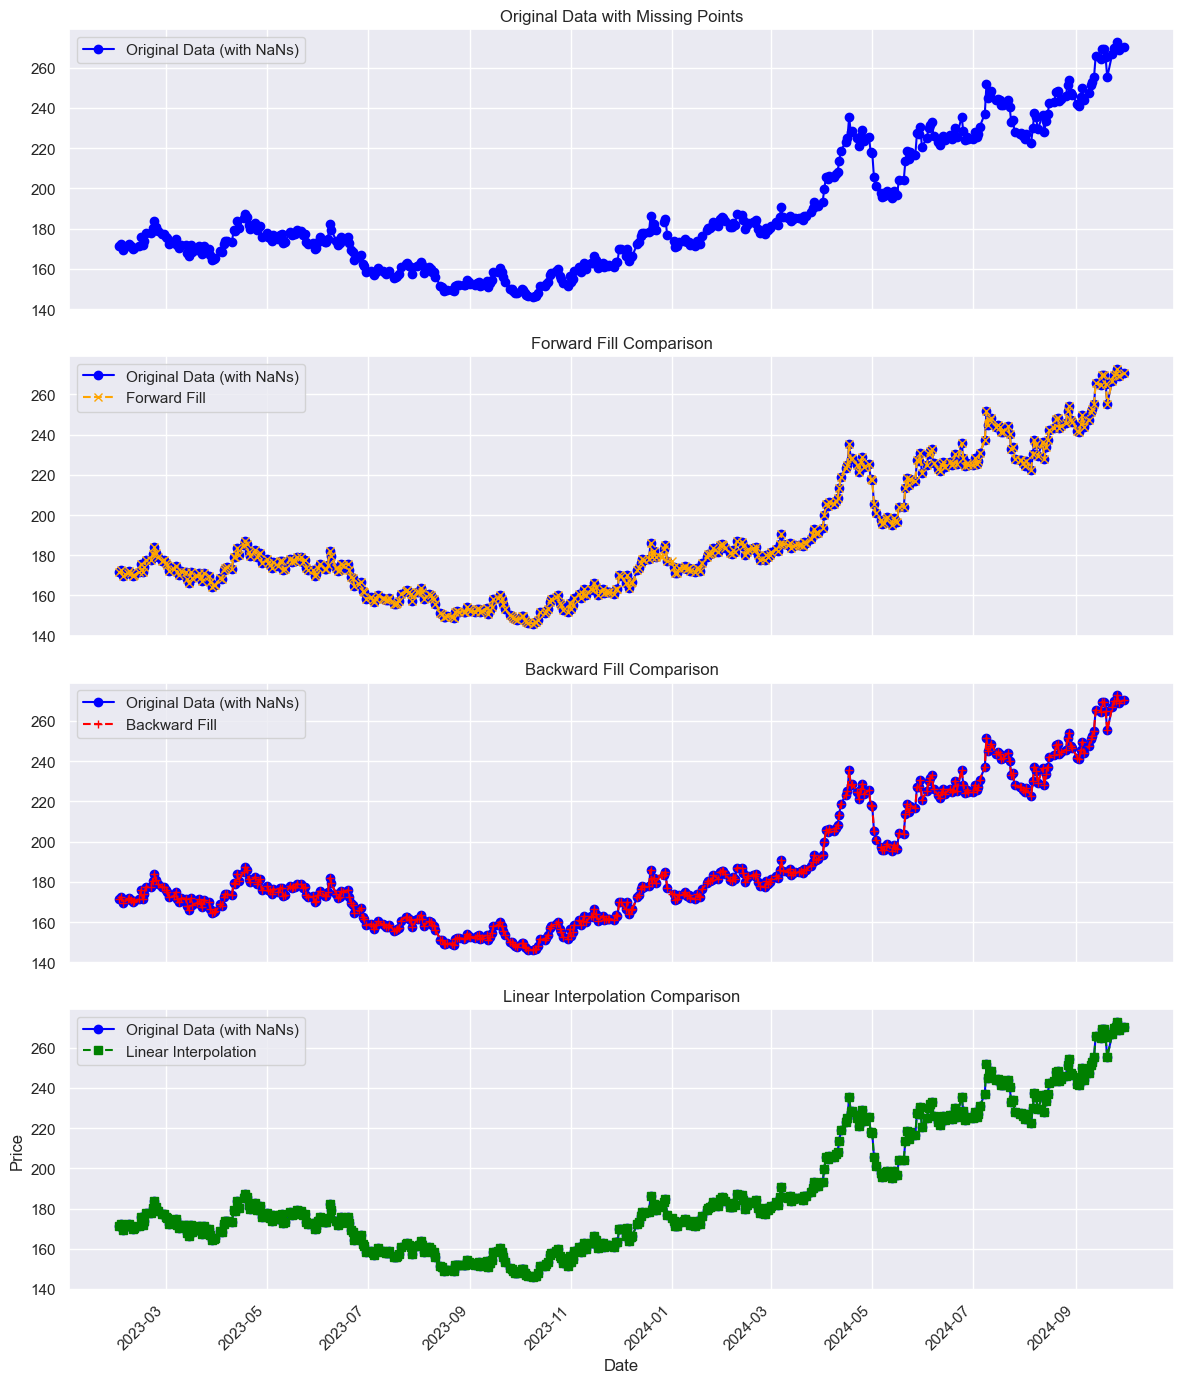

In [50]:
# Create a new DataFrame for comparison to avoid modifying the original 'copy'
compare_df = copy.copy()

# Apply imputation methods to create comparison columns
compare_df['price_forward_fill'] = copy['I-CIP'].ffill()
compare_df['price_backward_fill'] = copy['I-CIP'].bfill()
compare_df['price_interpolate'] = copy['I-CIP'].interpolate()

# Create subplots for visual comparison of imputation methods
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 14))

# Set date format for x-axis
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[3].xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Adjust interval as needed
axes[3].xaxis.set_minor_locator(mdates.MonthLocator())

# Plot the original data with missing points on each subplot for comparison
axes[0].plot(compare_df.index, compare_df['I-CIP'], label='Original Data (with NaNs)', color='blue', linestyle='-', marker='o')
axes[0].set_title('Original Data with Missing Points')
axes[0].legend()

# Forward Fill - plot both original and forward-filled data
axes[1].plot(compare_df.index, compare_df['I-CIP'], label='Original Data (with NaNs)', color='blue', linestyle='-', marker='o')
axes[1].plot(compare_df.index, compare_df['price_forward_fill'], label='Forward Fill', color='orange', linestyle='--', marker='x')
axes[1].set_title('Forward Fill Comparison')
axes[1].legend()

# Backward Fill - plot both original and backward-filled data
axes[2].plot(compare_df.index, compare_df['I-CIP'], label='Original Data (with NaNs)', color='blue', linestyle='-', marker='o')
axes[2].plot(compare_df.index, compare_df['price_backward_fill'], label='Backward Fill', color='red', linestyle='--', marker='+')
axes[2].set_title('Backward Fill Comparison')
axes[2].legend()

# Linear Interpolation - plot both original and interpolated data
axes[3].plot(compare_df.index, compare_df['I-CIP'], label='Original Data (with NaNs)', color='blue', linestyle='-', marker='o')
axes[3].plot(compare_df.index, compare_df['price_interpolate'], label='Linear Interpolation', color='green', linestyle='--', marker='s')
axes[3].set_title('Linear Interpolation Comparison')
axes[3].legend()

# Set labels and rotate date labels
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Price')
plt.setp(axes[3].get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Linear interpolation is typically the most appropriate for time series data because it provides a gradual transition between values, which better mimics natural fluctuations in price indices.
Forward and Backward Fill are simpler methods and may be suitable if you believe that missing values should hold steady from a previous or upcoming value, but they can introduce unrealistic flat segments.


https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

https://365datascience.com/tutorials/time-series-analysis-tutorials/pre-process-time-series-data/

### c. Adding linear interpolation to main dataset>

In [52]:
# Apply linear interpolation to fill missing values in the DataFrame
copy_interpolated = copy.interpolate(method='linear')

# Verify that there are no remaining NaN values
print(copy_interpolated.isna().sum())

# Display a sample of the DataFrame to check the interpolation results
copy_interpolated.head()
#print(copy_interpolated.shape())

I-CIP              0
colombian_milds    0
other_milds        0
brazilian_nat      0
robustas           0
dtype: int64


I-CIP  colombian_milds  other_milds  brazilian_nat  robustas
date                                                                     
2023-02-01  171.43           235.92       223.22         191.65    102.31
2023-02-02  172.50           237.34       226.26         192.86    102.00
2023-02-03  169.47           232.24       221.86         188.61    101.52
2023-02-06  171.29           235.17       224.80         190.77    102.02
2023-02-07  172.14           235.65       226.72         191.92    102.10

## 2.5 EDA with interpolated dataset

## a. boxplot with the interpolated data


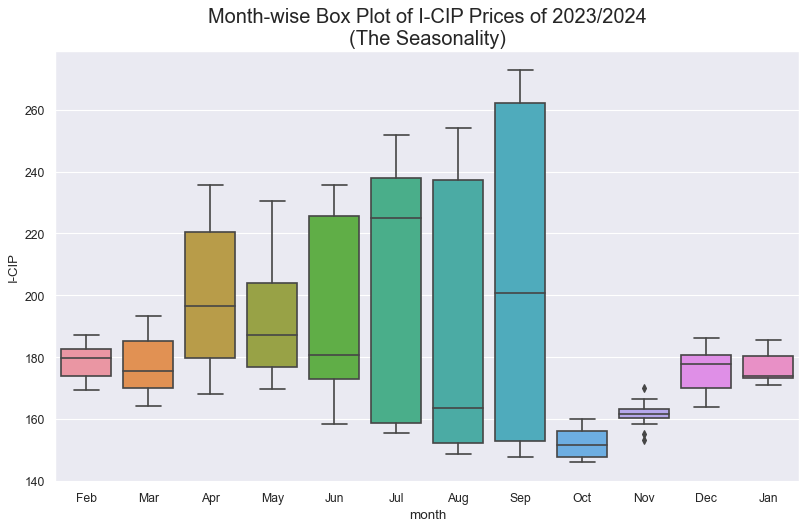

In [56]:



copy_interpolated['year'] = copy_interpolated.index.year
copy_interpolated['month'] = copy_interpolated.index.month_name().str[:3]  # This will give  the three-letter month abbreviation.

# Draw Plot
plt.figure(figsize=(12, 7), dpi=80)
sns.boxplot(x='month', y='I-CIP', data=copy_interpolated)

# Set Title
plt.title('Month-wise Box Plot of I-CIP Prices of 2023/2024\n(The Seasonality)', fontsize=18)

# Show the plot
plt.show()

## 2.5.1 Montly prices (boxplot) per year

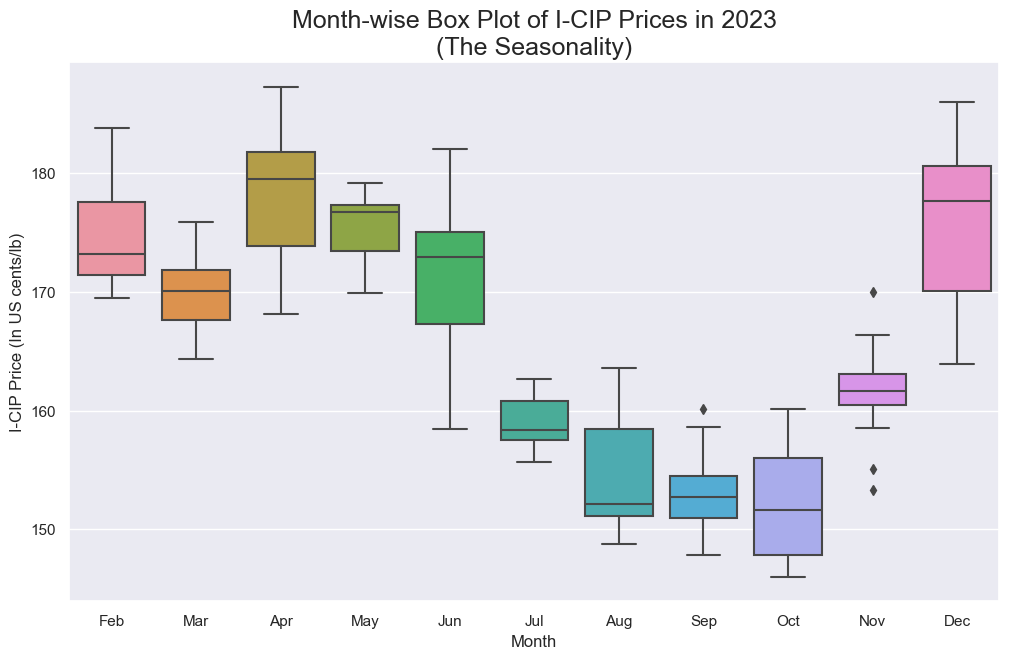

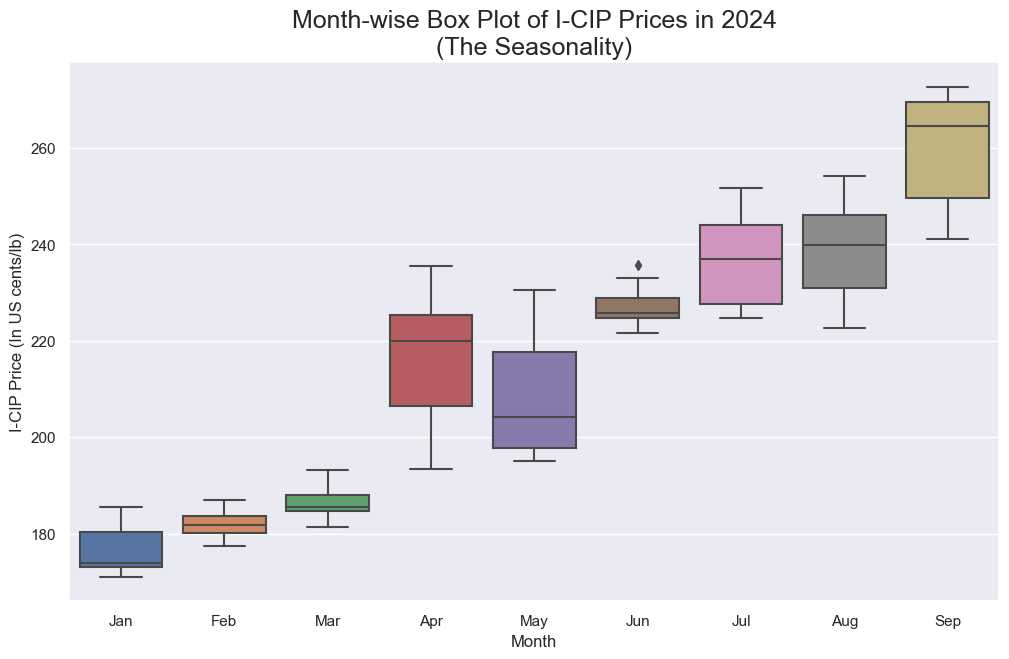

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-02-01  171.43           235.92       223.22         191.65    102.31   
2023-02-02  172.50           237.34       226.26         192.86    102.00   
2023-02-03  169.47           232.24       221.86         188.61    101.52   
2023-02-06  171.29           235.17       224.80         190.77    102.02   
2023-02-07  172.14           235.65       226.72         191.92    102.10   
...            ...              ...          ...            ...       ...   
2024-09-24  269.83           289.78       291.26         267.94    252.30   
2024-09-25  270.09           291.55       293.03         270.32    249.36   
2024-09-26  272.70           296.96       296.29         274.52    249.30   
2024-09-27  268.97           292.23       291.25         269.86    247.45   
2024-09-30  270.37           294.02       292.80         271.99    248.00   

            year month  
date                    
2023-02-01  2023   Feb  
2023-02-02  2023   Feb  
2023-02-03  2023   Feb  
2023-02-06  2023   Feb  
2023-02-07  2023   Feb  
...          ...   ...  
2024-09-24  2024   Sep  
2024-09-25  2024   Sep  
2024-09-26  2024   Sep  
2024-09-27  2024   Sep  
2024-09-30  2024   Sep  

[434 rows x 7 columns]

In [57]:
# Filter data by year
df_23 = copy_interpolated[copy_interpolated['year'] == 2023]
df_24 = copy_interpolated[copy_interpolated['year'] == 2024]

# Plot for 2023
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_23, order=['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2023\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

# Plot for 2024 (up to September)
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_24, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2024\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

copy_interpolated

In [58]:
###### plot monthy only by category 

2.5.1

## a. Outliers

In [59]:
# Filter rows where prices are outliers for each month
# 
q1 = icip_df.groupby('month')['I-CIP'].quantile(0.25)
q3 = icip_df.groupby('month')['I-CIP'].quantile(0.75)
iqr = q3 - q1

# Define outliers as points outside 1.5 * IQR
outliers = icip_df.apply(lambda x: (x['I-CIP'] < q1[x['month']] - 1.5 * iqr[x['month']]) |
                               (x['I-CIP'] > q3[x['month']] + 1.5 * iqr[x['month']]), axis=1)

# Display or analyze the outliers
outlier_data = icip_df[outliers]
outlier_data

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-11-01  153.32           187.15       186.58         158.95    117.80   
2023-11-02  155.03           190.74       190.54         161.85    116.54   
2023-11-30  169.99           206.20       207.56         180.84    126.65   

            year month  
date                    
2023-11-01  2023   Nov  
2023-11-02  2023   Nov  
2023-11-30  2023   Nov

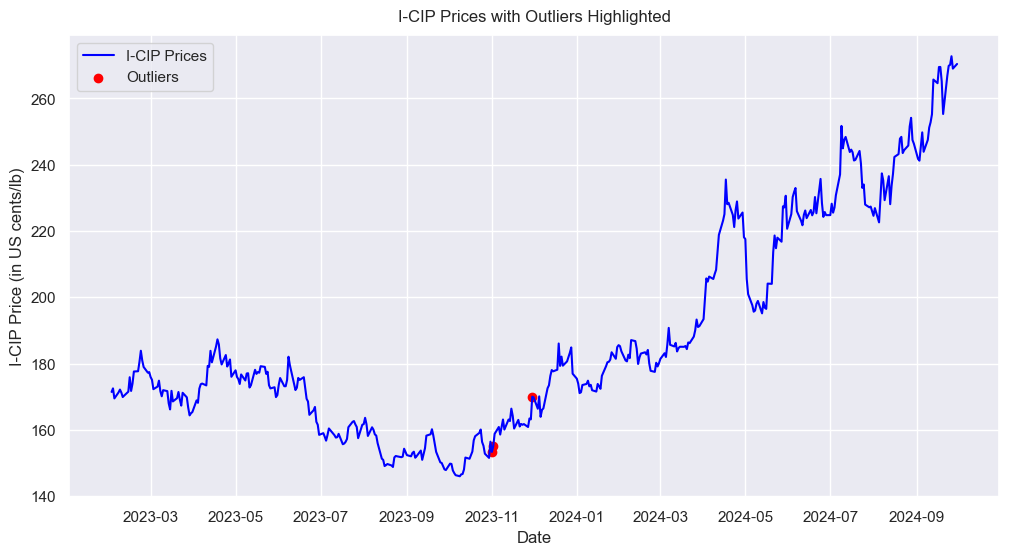

In [97]:

# Plot the I-CIP prices
plt.figure(figsize=(12, 6))
plt.plot(icip_df.index, new_df['I-CIP'], label='I-CIP Prices', color='blue')
plt.scatter(outlier_data.index, outlier_data['I-CIP'], color='red', label='Outliers')  # Highlight outliers

# Formatting the plot
plt.title('I-CIP Prices with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('I-CIP Price (in US cents/lb)')
plt.legend()
plt.show()


b. Explore Correlations with Other Variables


In [98]:
# Step 1: Select the relevant columns (e.g., I-CIP and other coffee categories) for the outliers
outlier_correlation = outlier_data[['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']]

# Step 2: Calculate correlations
outlier_corr = outlier_correlation.corr()
print(outlier_corr)

                    I-CIP  colombian_milds  other_milds  brazilian_nat  \
I-CIP            1.000000         0.996398     0.996372       0.999583   
colombian_milds  0.996398         1.000000     1.000000       0.998432   
other_milds      0.996372         1.000000     1.000000       0.998415   
brazilian_nat    0.999583         0.998432     0.998415       1.000000   
robustas         0.978453         0.957420     0.957331       0.972080   

                 robustas  
I-CIP            0.978453  
colombian_milds  0.957420  
other_milds      0.957331  
brazilian_nat    0.972080  
robustas         1.000000  


### c. Year-over-Year Monthly Comparison:

This plot aims to compare the avarage of icip prices in 2023 and 2024, to highlight differences in each year.

Overall, the year of 24 is represented by higher average, confirming the upward trend seen in line plots in item c.



In [62]:
import calendar

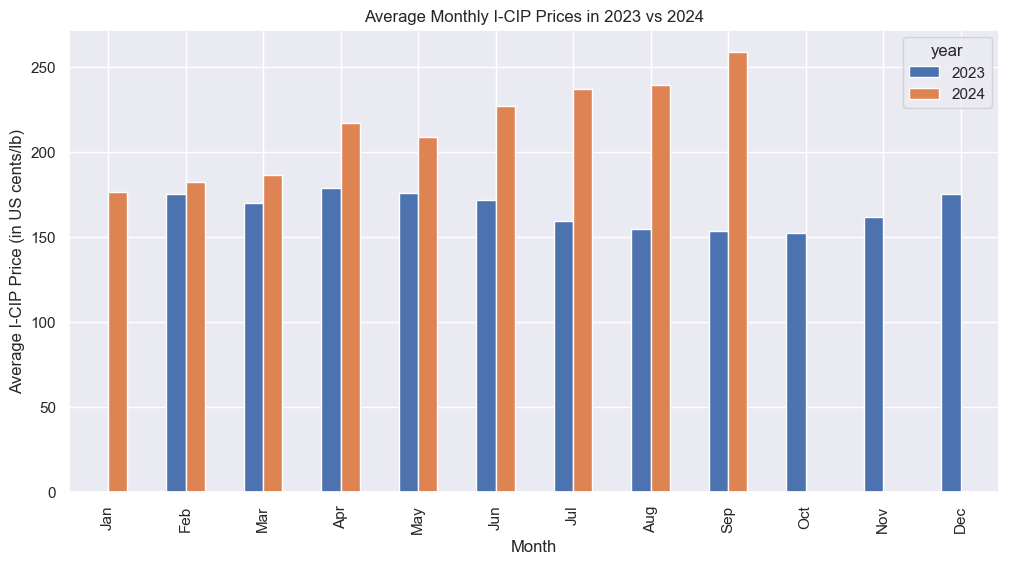

In [63]:
# Set the month order to ensure chronological sorting
month_order = list(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']
icip_df['month'] = pd.Categorical(icip_df['month'], categories=month_order, ordered=True)

# Monthly average comparison
monthly_avg = icip_df.groupby(['year', 'month'])['I-CIP'].mean().unstack(level=0)
monthly_avg.plot(kind='bar', figsize=(12, 6))
plt.title('Average Monthly I-CIP Prices in 2023 vs 2024')
plt.xlabel('Month')
plt.ylabel('Average I-CIP Price (in US cents/lb)')
plt.show()

months appear in alphabetical order instead of chronological? >>> **adjust\!**

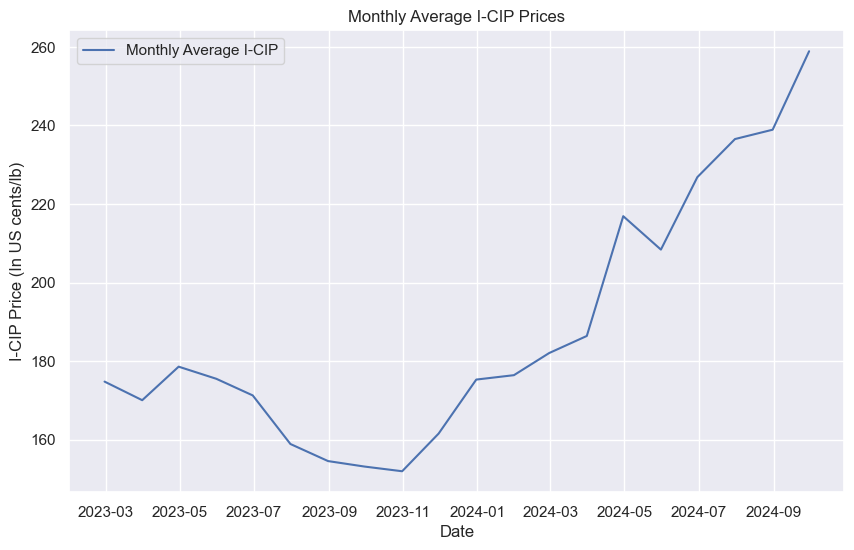

In [64]:
#Monthly Average Plot
monthly_avg = icip_df['I-CIP'].resample('M').mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg, label="Monthly Average I-CIP")
plt.title("Monthly Average I-CIP Prices")
plt.xlabel("Date")
plt.ylabel("I-CIP Price (In US cents/lb)")
plt.legend()
plt.show()



### d.  Monthly Average I-CIP Prices with Regional Harvest Annotations

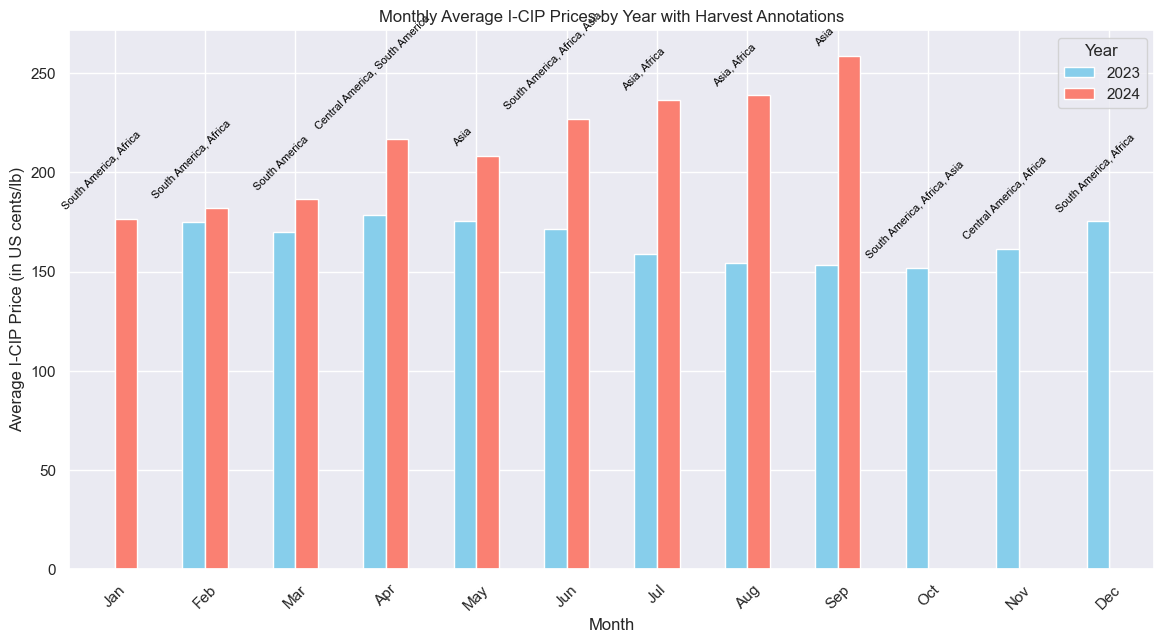

In [65]:
# Set the month order to ensure chronological sorting
#month_order = list(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']
#icip_df['month'] = pd.Categorical(icip_df['month'], categories=month_order, ordered=True)

# Group by both year and month to keep month names in chronological order
monthly_avg_df = icip_df.groupby([icip_df.index.year, 'month'])['I-CIP'].mean().unstack(level=0)

# Create the plot with annotations of harvest 
plt.figure(figsize=(14, 7))
monthly_avg_df.plot(kind='bar', color=['skyblue', 'salmon'], ax=plt.gca())
plt.xlabel('Month')
plt.ylabel('Average I-CIP Price (in US cents/lb)')
plt.title('Monthly Average I-CIP Prices by Year with Harvest Annotations')

# Annotate months with regional harvests (approximately)
harvest_annotations = {
    'Jan': 'South America, Africa',
    'Feb': 'South America, Africa',
    'Mar': 'South America',
    'Apr': 'Central America, South America',
    'May': 'Asia',
    'Jun': 'South America, Africa, Asia',
    'Jul': 'Asia, Africa',
    'Aug': 'Asia, Africa',
    'Sep': 'Asia',
    'Oct': 'South America, Africa, Asia',
    'Nov': 'Central America, Africa',
    'Dec': 'South America, Africa'
}

# Add annotations at 45-degree angle for readability
for month_idx, (month, regions) in enumerate(harvest_annotations.items()):
    plt.text(month_idx - 0.15, monthly_avg_df.loc[month].max() + 5, 
             regions, ha='center', rotation=45, color='black', fontsize=8)

# Adjust x-axis labels
plt.xticks(rotation=45)
plt.legend(title="Year", loc="upper right")
plt.show()



# harverst dates extracted from 
#Source: https://coffeehunter.com/coffee-seasonality/ accessed on 30/10
# https://www.fairmountaincoffee.com/category-s/102.htm accessedon 30/10

#### Heatmap of Monthly Price Averages 

The heatmat below aims to identify months where prices tend to dip or spike, then cross-reference with known harvest periods. The color intensity provides a quick overview of price levels each month.

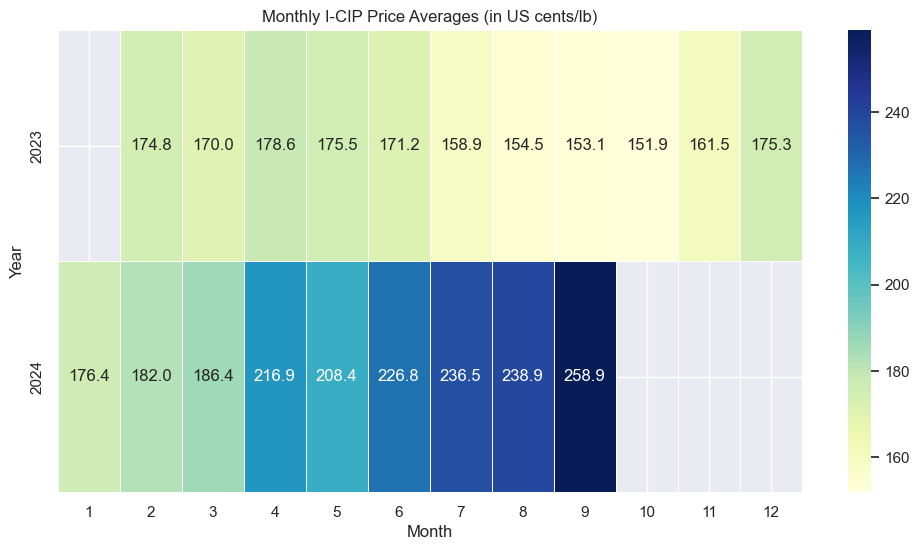

In [66]:
# Create a DataFrame for monthly averages
monthly_avg_df = icip_df.groupby([icip_df.index.year, icip_df.index.month])['I-CIP'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_avg_df, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=0.5)
plt.title('Monthly I-CIP Price Averages (in US cents/lb)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [69]:
#new_df.index

In [68]:
new_df = copy_interpolated
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2023-02-01 to 2024-09-30
Freq: B
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I-CIP            434 non-null    float64
 1   colombian_milds  434 non-null    float64
 2   other_milds      434 non-null    float64
 3   brazilian_nat    434 non-null    float64
 4   robustas         434 non-null    float64
 5   year             434 non-null    int64  
 6   month            434 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 43.3+ KB


## Monthly variation (%) of for each category
### ICIP and its components 


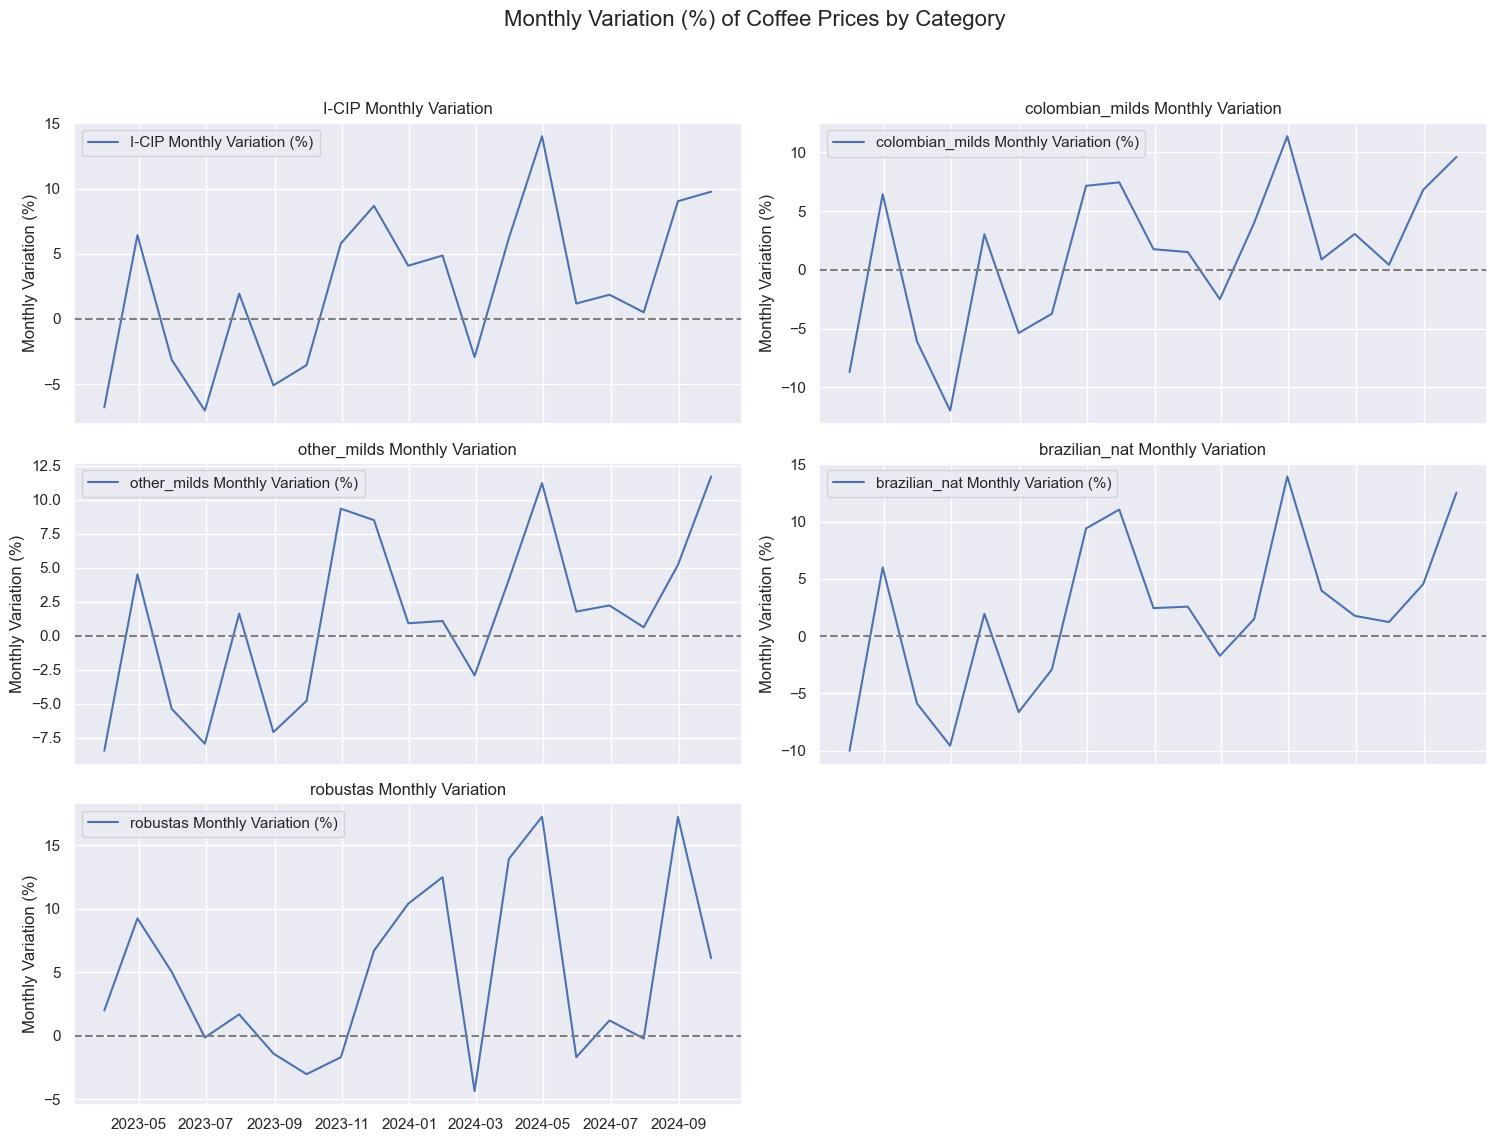

In [70]:
# Resample data to monthly frequency and calculate percentage change
monthly_variations = new_df[['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']].resample('M').ffill().pct_change() * 100

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
fig.suptitle("Monthly Variation (%) of Coffee Prices by Category", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of categories to plot
categories = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']

# Plot each category's monthly variation in its own subplot
for i, category in enumerate(categories):
    axes[i].plot(monthly_variations.index, monthly_variations[category], label=f'{category} Monthly Variation (%)')
    axes[i].axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0
    axes[i].set_title(f"{category} Monthly Variation")
    axes[i].set_ylabel("Monthly Variation (%)")
    axes[i].legend()

# Hide any unused subplots
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

## Weekly variations


Resampling the data to weekly frequency and calculate the percentage change from one week to the next

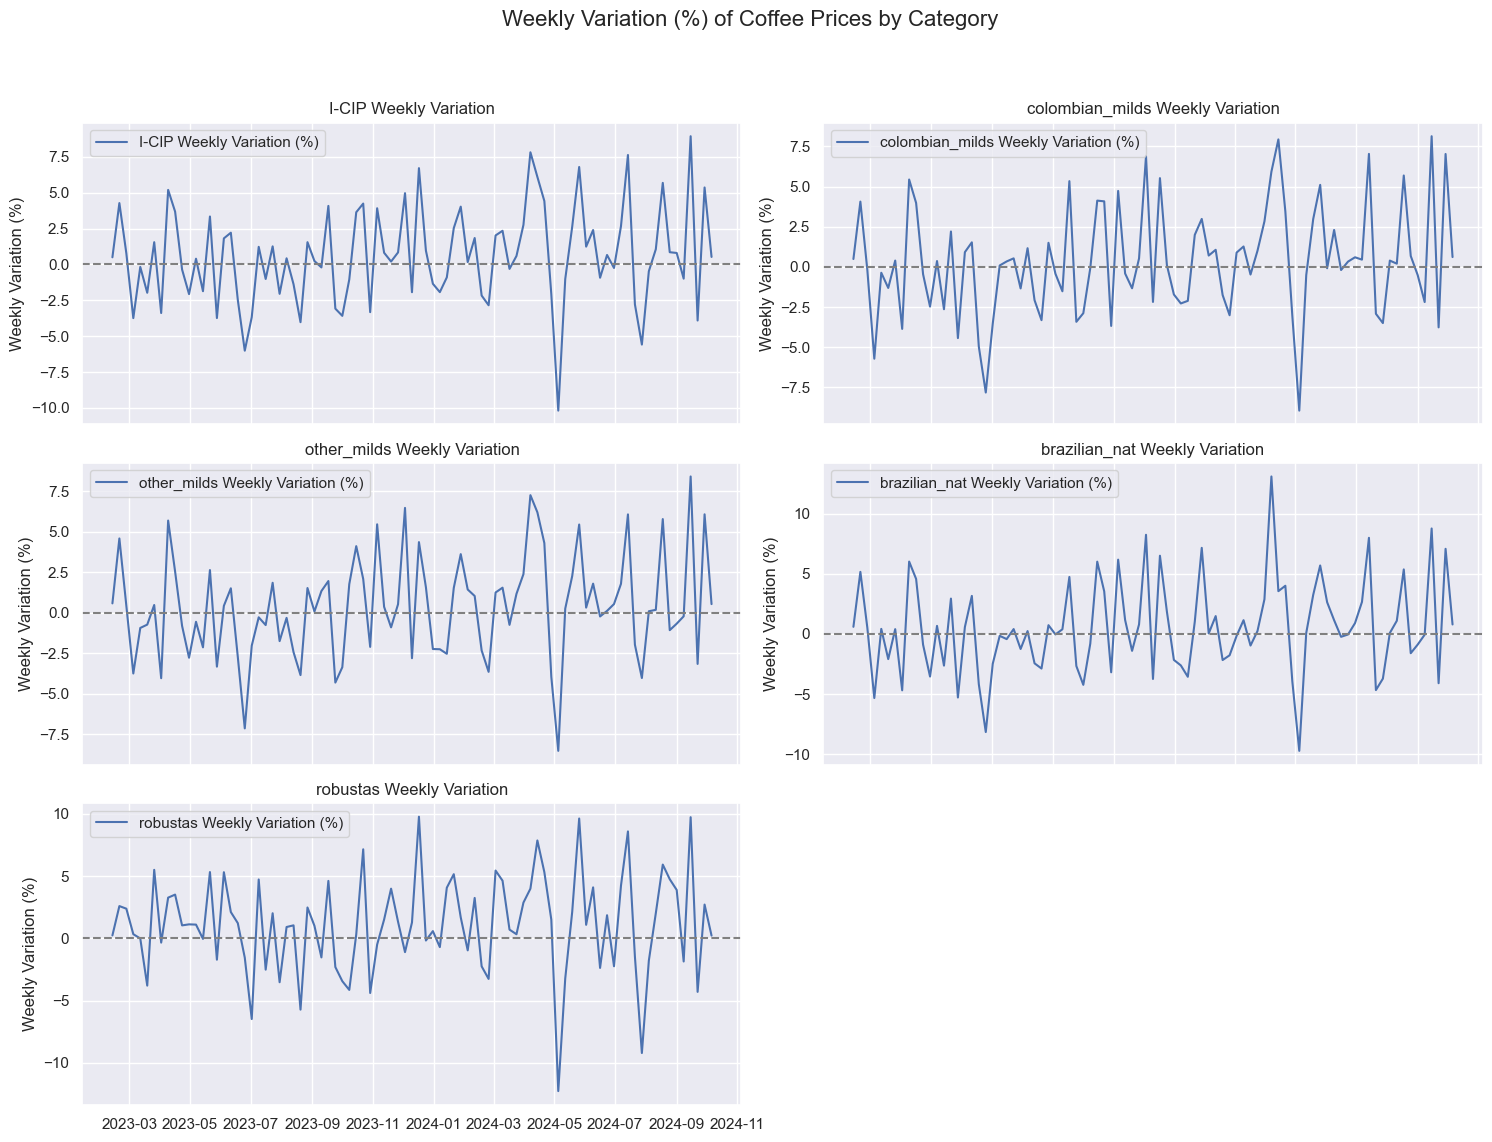

In [71]:
# Calculate weekly percentage change (variation) for each category
weekly_variations = new_df[['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']].resample('W').ffill().pct_change() * 100

# Plot each category's weekly variation in separate subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
fig.suptitle("Weekly Variation (%) of Coffee Prices by Category", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of categories to plot
categories = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']

# Plot each category's weekly variation
for i, category in enumerate(categories):
    axes[i].plot(weekly_variations.index, weekly_variations[category], label=f'{category} Weekly Variation (%)')
    axes[i].axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0
    axes[i].set_title(f"{category} Weekly Variation")
    axes[i].set_ylabel("Weekly Variation (%)")
    axes[i].legend()

# Hide any unused subplots
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

## Daily variations


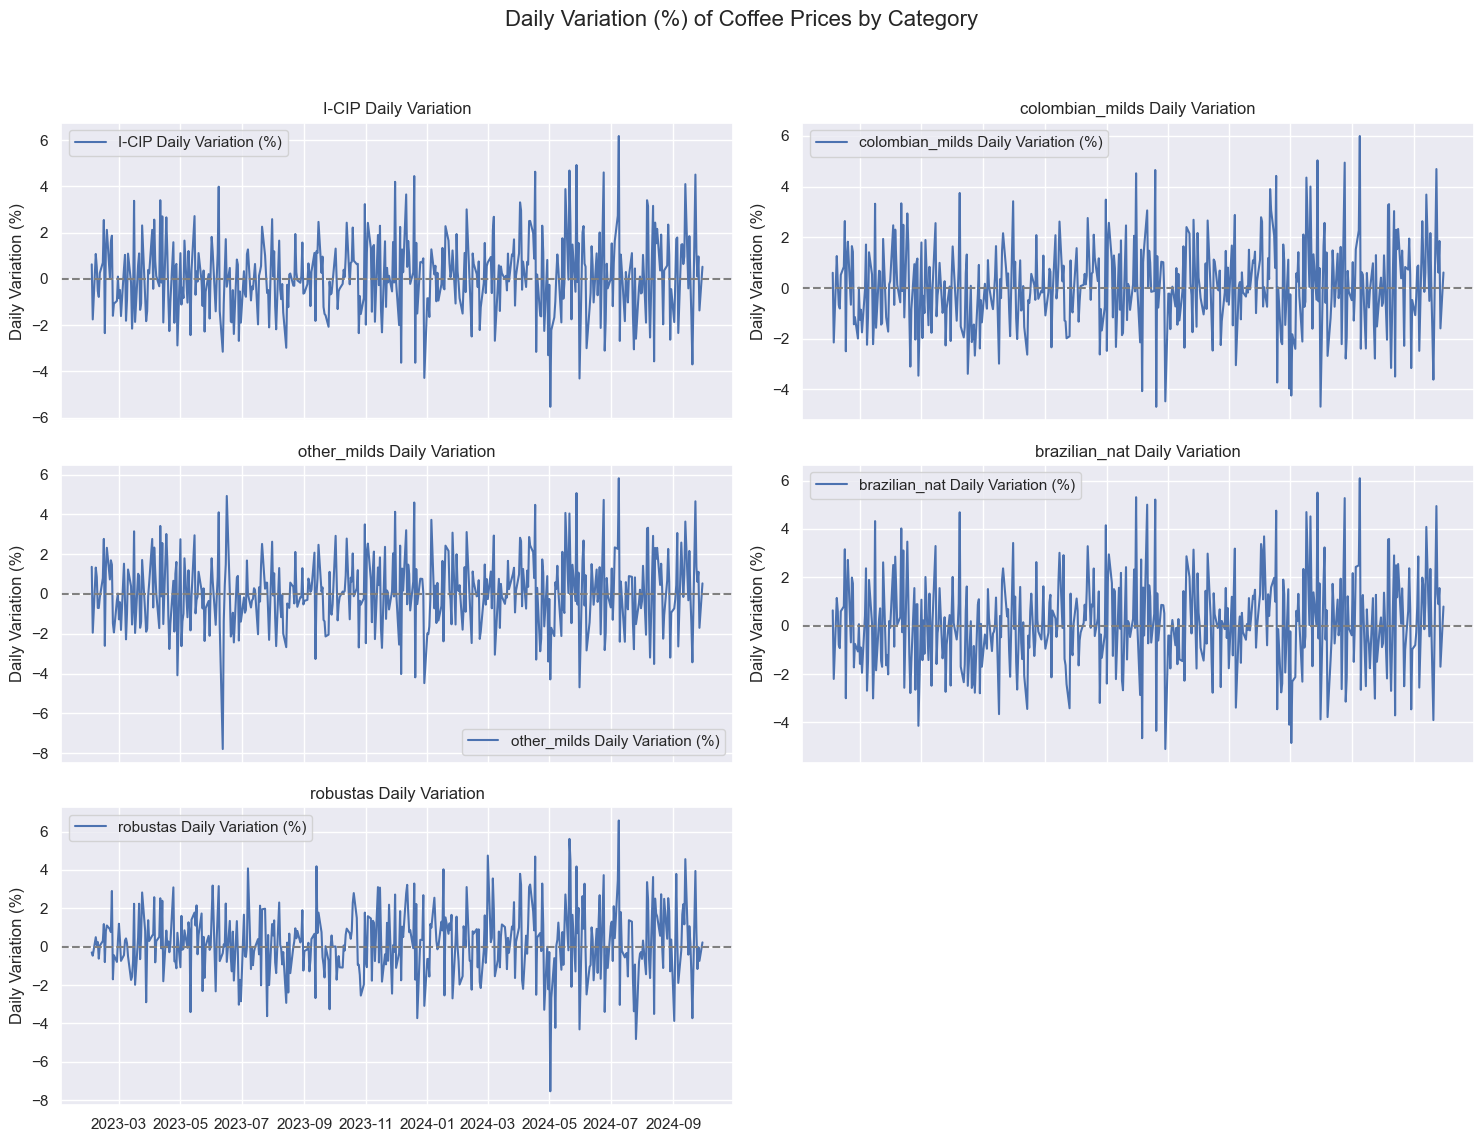

In [72]:
# Calculate daily percentage change (variation) for each category
daily_variations = new_df[['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']].pct_change() * 100

# Plot each category's daily variation in separate subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
fig.suptitle("Daily Variation (%) of Coffee Prices by Category", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each category's daily variation
for i, category in enumerate(categories):
    axes[i].plot(daily_variations.index, daily_variations[category], label=f'{category} Daily Variation (%)')
    axes[i].axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0
    axes[i].set_title(f"{category} Daily Variation")
    axes[i].set_ylabel("Daily Variation (%)")
    axes[i].legend()

# Hide any unused subplots
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

## Highlight the high volatility periods

## Weekly and daily

Based on industry standards, as cited by Lordemann et al(2021) 

- Weekly Volatility Threshold: Flag weeks with variations above ±5%.
Weekly Threshold: Weekly changes greater than ±5% are often used in commodity markets to flag significant shifts, particularly for goods with high seasonality or sensitivity to external events.

- Daily Volatility Threshold: Flag days with variations above ±3%.
Daily Threshold: In financial markets, daily price changes greater than ±3% are often considered high volatility. Since coffee prices can be sensitive to market and environmental factors, this threshold could be reasonable.

Source: https://repositorio.cepal.org/server/api/core/bitstreams/ca31a1a5-c246-49e4-81e0-be62a16f3c26/content

In [73]:
# Define thresholds
weekly_threshold = 5  # Weekly variation above 5% (or -5%) considered volatile
daily_threshold = 3   # Daily variation above 3% (or -3%) considered volatile

# Find volatile weeks
volatile_weeks = weekly_variations[(weekly_variations > weekly_threshold) | (weekly_variations < -weekly_threshold)].dropna(how='all')
print("Volatile Weeks:")
print(volatile_weeks)

# Find volatile days
volatile_days = daily_variations[(daily_variations > daily_threshold) | (daily_variations < -daily_threshold)].dropna(how='all')
print("Volatile Days:")
print(volatile_days)

Volatile Weeks:
                I-CIP  colombian_milds  other_milds  brazilian_nat   robustas
date                                                                         
2023-02-19        NaN              NaN          NaN       5.165235        NaN
2023-03-05        NaN        -5.709807          NaN      -5.330342        NaN
2023-03-26        NaN              NaN          NaN            NaN   5.505476
2023-04-09   5.194413         5.434933     5.690373       6.023624        NaN
2023-05-21        NaN              NaN          NaN            NaN   5.327321
2023-05-28        NaN              NaN          NaN      -5.286851        NaN
2023-06-04        NaN              NaN          NaN            NaN   5.315373
2023-06-25  -6.015424        -7.813810    -7.140521      -8.160089        NaN
2023-07-02        NaN              NaN          NaN            NaN  -6.480018
2023-08-20        NaN              NaN          NaN            NaN  -5.725281
2023-09-17        NaN         5.334878          

## Visualise Volatile periods


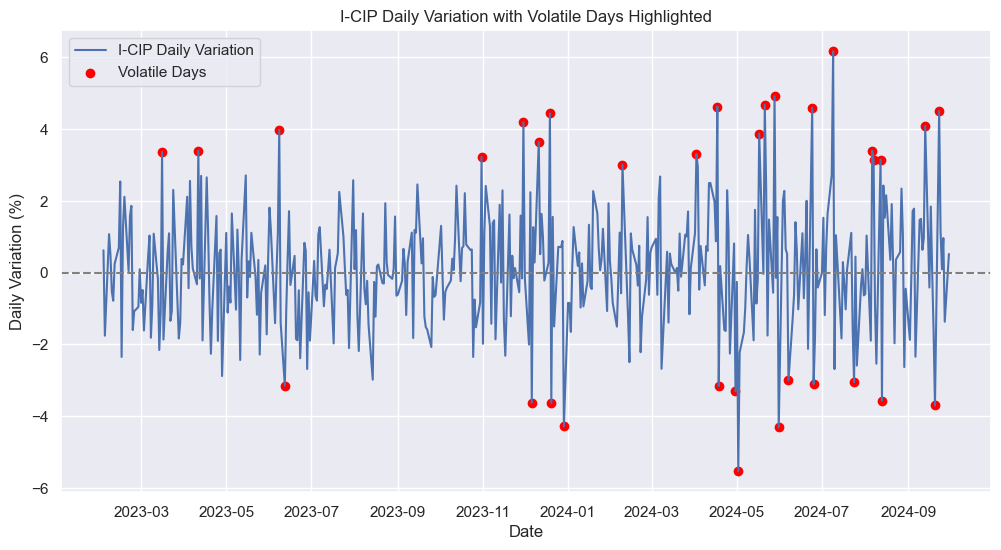

In [74]:
import matplotlib.pyplot as plt

# Plot daily variation with volatile days highlighted
plt.figure(figsize=(12, 6))
plt.plot(daily_variations.index, daily_variations['I-CIP'], label='I-CIP Daily Variation')
plt.scatter(volatile_days.index, volatile_days['I-CIP'], color='red', label='Volatile Days', marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("I-CIP Daily Variation with Volatile Days Highlighted")
plt.xlabel("Date")
plt.ylabel("Daily Variation (%)")
plt.legend()
plt.show()

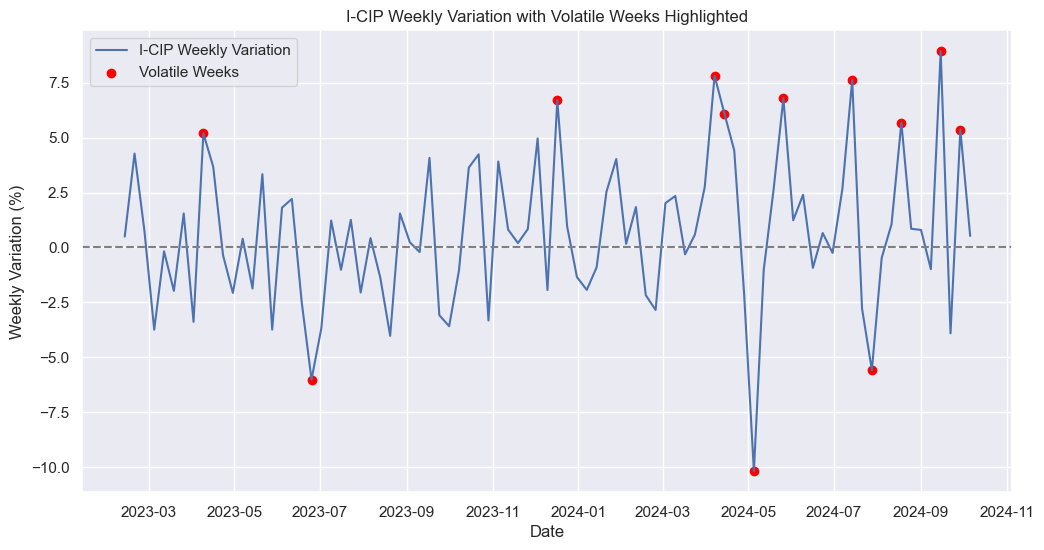

In [75]:
# Similarly, you can plot for weekly variations
plt.figure(figsize=(12, 6))
plt.plot(weekly_variations.index, weekly_variations['I-CIP'], label='I-CIP Weekly Variation')
plt.scatter(volatile_weeks.index, volatile_weeks['I-CIP'], color='red', label='Volatile Weeks', marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("I-CIP Weekly Variation with Volatile Weeks Highlighted")
plt.xlabel("Date")
plt.ylabel("Weekly Variation (%)")
plt.legend()
plt.show()

 Rolling Volatility (Standard Deviation)
Another approach for pinpointing volatility through a sliding window using a rolling standard deviation.
The code belows attemp tto do it


In [76]:
# Calculate 4-week rolling standard deviation for each category
weekly_rolling_volatility = weekly_variations.rolling(window=4).std()

# Identify periods where rolling volatility exceeds a chosen threshold
high_weekly_volatility = weekly_rolling_volatility[weekly_rolling_volatility > weekly_threshold]
print("High Weekly Volatility Periods:")
print(high_weekly_volatility.dropna(how='all'))

High Weekly Volatility Periods:
               I-CIP  colombian_milds  other_milds  brazilian_nat  robustas
date                                                                       
2023-06-25       NaN              NaN          NaN       5.029956       NaN
2023-10-22       NaN              NaN          NaN            NaN  5.172688
2023-10-29       NaN              NaN          NaN            NaN  5.398303
2023-12-10       NaN              NaN          NaN       5.193119       NaN
2023-12-17       NaN              NaN          NaN       5.483918       NaN
2023-12-24       NaN              NaN          NaN       5.369622       NaN
2024-04-07       NaN              NaN          NaN       6.396991       NaN
2024-04-14       NaN              NaN          NaN       5.623291       NaN
2024-04-28       NaN              NaN     5.085454       6.970987       NaN
2024-05-05  7.397074         7.389744     6.934749       6.570508  8.973328
2024-05-12  6.029784         5.193766     5.512950      

In [77]:
# Calculate 7-day rolling standard deviation for each category
daily_rolling_volatility = daily_variations.rolling(window=7).std()

# Identify periods where rolling volatility exceeds a chosen threshold
high_daily_volatility = daily_rolling_volatility[daily_rolling_volatility > daily_threshold]
print("High Daily Volatility Periods:")
print(high_daily_volatility.dropna(how='all'))

High Daily Volatility Periods:
               I-CIP  colombian_milds  other_milds  brazilian_nat  robustas
date                                                                       
2023-06-12       NaN              NaN     3.639344            NaN       NaN
2023-06-13       NaN              NaN     3.583895            NaN       NaN
2023-06-14       NaN              NaN     3.618751            NaN       NaN
2023-06-15       NaN              NaN     3.719875            NaN       NaN
2023-06-16       NaN              NaN     4.256186            NaN       NaN
2023-06-19       NaN              NaN     3.868112            NaN       NaN
2023-06-20       NaN              NaN     3.896550            NaN       NaN
2023-12-06       NaN              NaN          NaN       3.409196       NaN
2023-12-07       NaN              NaN          NaN       3.351513       NaN
2023-12-08       NaN              NaN          NaN       3.360079       NaN
2023-12-11       NaN              NaN          NaN       

## Checking periods of high volatility across all variables?

## Daily variation

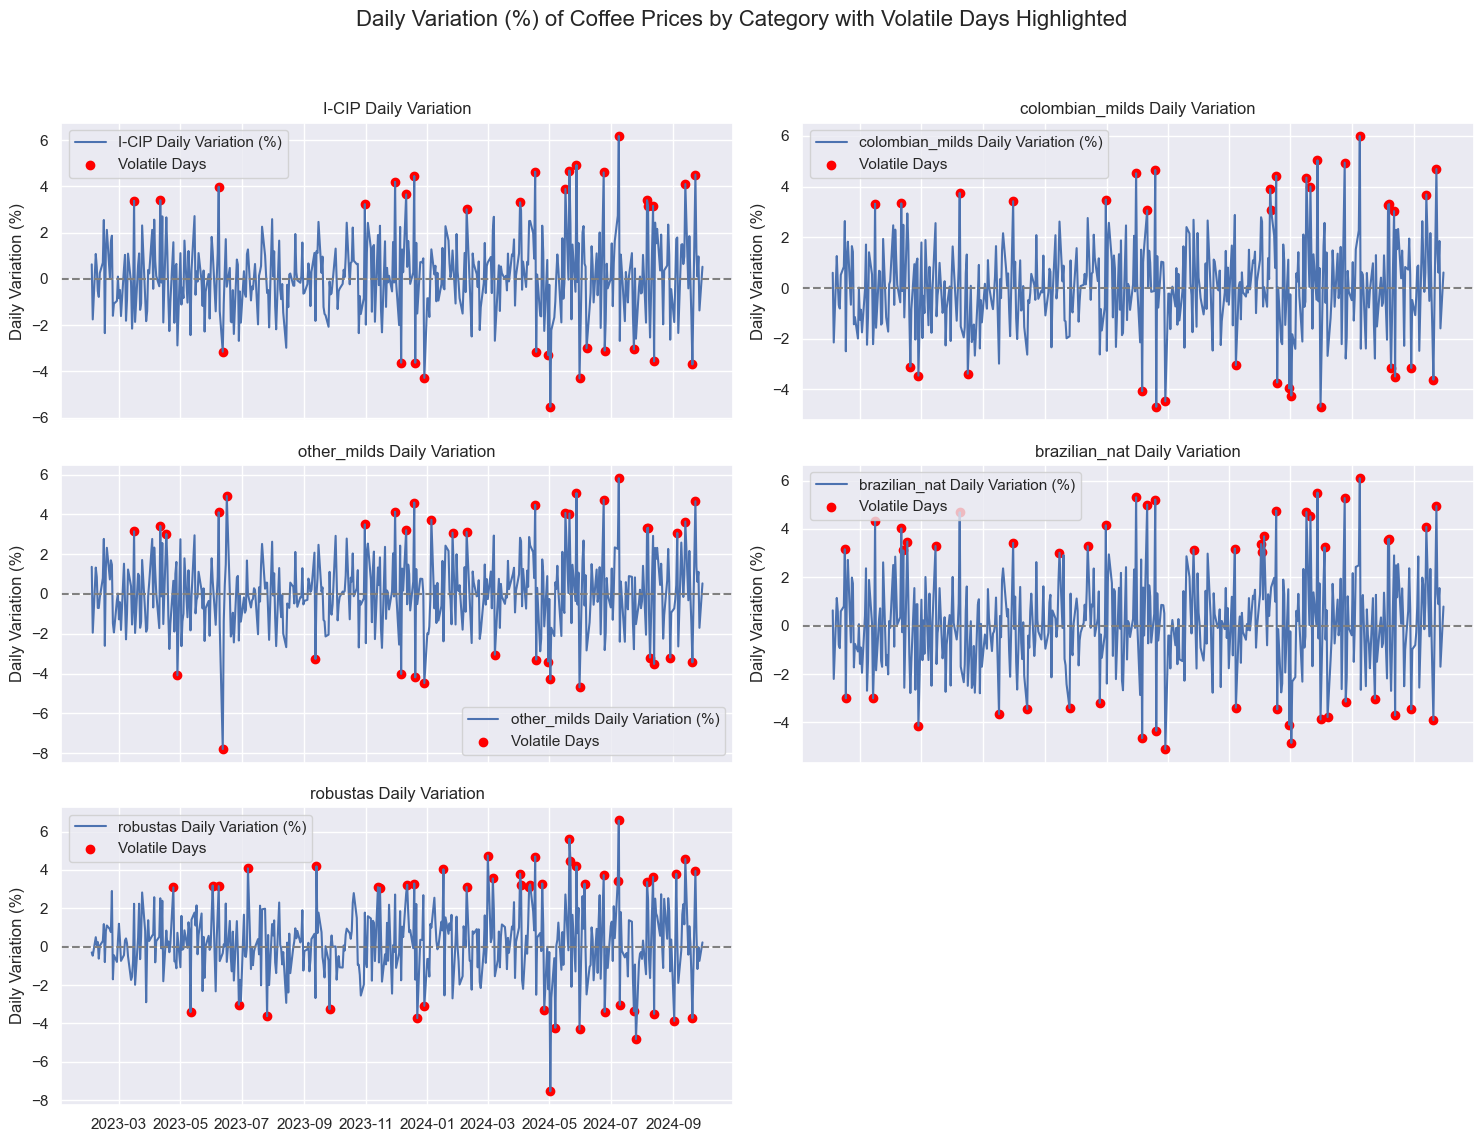

In [78]:
# Define your volatility threshold for daily variations
daily_threshold = 3

# Find volatile days for each category
daily_volatile_days = daily_variations[(daily_variations > daily_threshold) | (daily_variations < -daily_threshold)]

# Set up subplots for daily variations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
fig.suptitle("Daily Variation (%) of Coffee Prices by Category with Volatile Days Highlighted", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each category's daily variation with volatile days highlighted
for i, category in enumerate(categories):
    axes[i].plot(daily_variations.index, daily_variations[category], label=f'{category} Daily Variation (%)')
    axes[i].scatter(daily_volatile_days.index, daily_volatile_days[category], color='red', label='Volatile Days', marker='o')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].set_title(f"{category} Daily Variation")
    axes[i].set_ylabel("Daily Variation (%)")
    axes[i].legend()

# Hide any unused subplots if there are extra spots
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Weekly variation

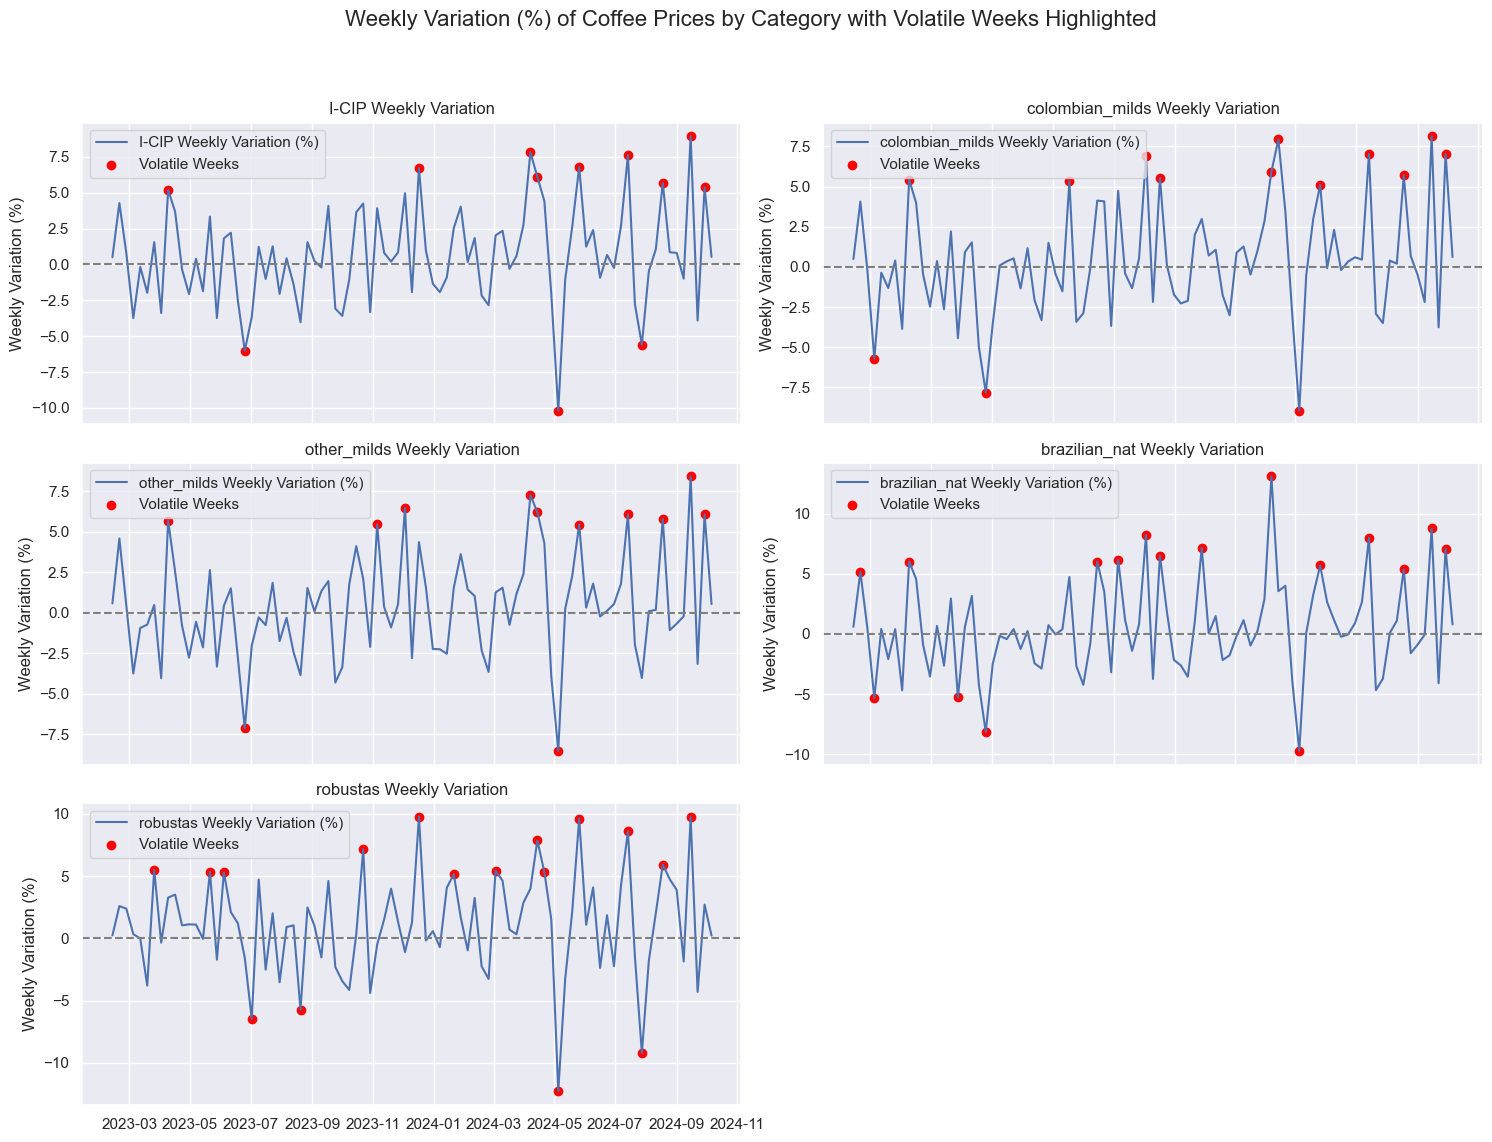

In [79]:
# Assuming categories is the list of your column names, like:
categories = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']

# Define volatility threshold for weekly variations
weekly_threshold = 5

# Find volatile weeks for each category
weekly_volatile_weeks = weekly_variations[(weekly_variations > weekly_threshold) | (weekly_variations < -weekly_threshold)]

# Set up subplots for weekly variations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
fig.suptitle("Weekly Variation (%) of Coffee Prices by Category with Volatile Weeks Highlighted", fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each category's weekly variation with volatile weeks highlighted
for i, category in enumerate(categories):
    axes[i].plot(weekly_variations.index, weekly_variations[category], label=f'{category} Weekly Variation (%)')
    axes[i].scatter(weekly_volatile_weeks.index, weekly_volatile_weeks[category], color='red', label='Volatile Weeks', marker='o')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].set_title(f"{category} Weekly Variation")
    axes[i].set_ylabel("Weekly Variation (%)")
    axes[i].legend()

# Hide any unused subplots if there are extra spots
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [83]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
  Using cached pyproj-3.7.0.tar.gz (225 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      proj executable not found. Please set the PROJ_DIR variable. For more information see: https://pyproj4.github.io/pyproj/stable/installation.html
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Note: you may need to restart the kernel to use updated packages.


In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'geopandas'

In [ ]:


# Load a world shapefile dataset (such as Natural Earth)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define crop years as dictionary mapping countries to their crop start months
crop_years = {
    "April": ["Angola", "Indonesia", "Paraguay", "Bolivia", "Madagascar", "Peru", "Brazil", "Malawi", "Rwanda", "Burundi", "Papua New Guinea", "Zimbabwe", "Ecuador"],
    "July": ["Congo", "Haiti", "United Republic of Tanzania", "Cuba", "Philippines", "Zambia", "Dominican Republic"],
    "October": ["Benin", "Ghana", "Nigeria", "Cameroon", "Guatemala", "Panama", "Central African Republic", "Guinea", "Sierra Leone", "Colombia", "Honduras", "Sri Lanka", "Costa Rica", "India", "Thailand", "Cote d'Ivoire", "Jamaica", "Togo", "Democratic Republic of the Congo", "Kenya", "Trinidad & Tobago", "El Salvador", "Liberia", "Uganda", "Equatorial Guinea", "Mexico", "Venezuela", "Ethiopia", "Nicaragua", "Vietnam", "Gabon"]
}

# Add a new column to the world GeoDataFrame for crop year
world["crop_year"] = world["name"].apply(lambda x: "April" if x in crop_years["April"] else "July" if x in crop_years["July"] else "October" if x in crop_years["October"] else "Other")

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column="crop_year", cmap="Set2", legend=True, ax=ax)
plt.title("Coffee Producing Countries and Their Crop Year Start Dates")
plt.show()

## 2.4 Distribuition

In [85]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2023-02-01 to 2024-09-30
Freq: B
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I-CIP            434 non-null    float64
 1   colombian_milds  434 non-null    float64
 2   other_milds      434 non-null    float64
 3   brazilian_nat    434 non-null    float64
 4   robustas         434 non-null    float64
 5   year             434 non-null    int64  
 6   month            434 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 43.3+ KB


[Text(0.5, 0, 'i-cip'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'ICO Composite Prices  Histogram')]

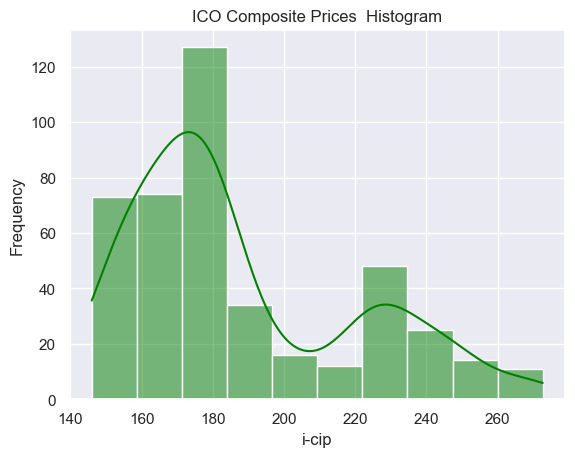

In [86]:
# Changing some of the aesthetics... adding in a kernel desnity estimate:
ax = sns.histplot(new_df['I-CIP'], kde=True, color ='green')
ax.set(xlabel='i-cip',
       ylabel='Frequency',
       title ="ICO Composite Prices  Histogram")

From the histogram above, we can see the data doensnt show a normal distribution of values, the graph below a kde is added to the plot to make it even clearer. The Bimodal distribution indicates the presence of two distinct groups within the dataset, each with its own central tendency. (two populations in the sample)


This often suggests that this dataset may be influenced by two different underlying processes or conditions. In terms of comodity markets, for example, a distribution like this one might reflect different market dynamics or consumption patterns across two separate seasons or market segments. (**find ref**) 

The next step is to consider whether these modes represent meaningful segments that require additional analysis or modeling strategies. By fitting a Gaussian Mixture Model or exploring the data's skewness and kurtosis, we can dive deeper into understanding the characteristics of these subgroups, which can give more insight son how to proceed to tailoring the forecasting models.

In [87]:
# Create histogram
fig = px.histogram(new_df['I-CIP'], x='I-CIP', nbins=30) #changing the number of bins makes the curve clearer, 10, 20 were also used

# Update layout
fig.update_layout(
    title='I-CIP Histogram',
    xaxis_title='Price',
    yaxis_title='Frequency'
)

# Show plot
fig.show()

From the histogram above, we can see the data doensnt show a normal distribution of values, the graph below a kde is added to the plot to make it even clearer. The Bimodal distribution indicates the presence of two distinct groups within the dataset, each with its own central tendency. (two populations in the sample)


This often suggests that this dataset may be influenced by two different underlying processes or conditions. In terms of comodity markets, for example, a distribution like this one might reflect different market dynamics or consumption patterns across two separate seasons or market segments.
The next step is to consider whether these modes represent meaningful segments that require additional analysis or modeling strategies. By fitting a Gaussian Mixture Model or exploring the data's skewness and kurtosis, we can dive deeper into understanding the characteristics of these subgroups, which can give more insight son how to proceed to tailoring the forecasting models.

In [ ]:

# Create a figure with two subplots to check for distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram of icip prices in the first subplot
axs[0].hist(copy['I-CIP'], bins=10)
axs[0].set_title('Histogram of I-CIP values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot probability plot of prices in the second subplot
stats.probplot(copy['I-CIP'], dist='norm', plot=axs[1])
axs[1].set_title('Probability Plot of Values')

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

the data shows some characteristics of a normal distribution but with potential signs of bimodality and the presence of outliers or heavy tails. This can often happen in real-world data where multiple factors contribute to the observed values, which can lead to more complex distributions deviating from the ideally normal dist.

### checking skewness of data

from the plot below we see the data is presenting a bimodal distribuition, which indicates the non normality of values. 

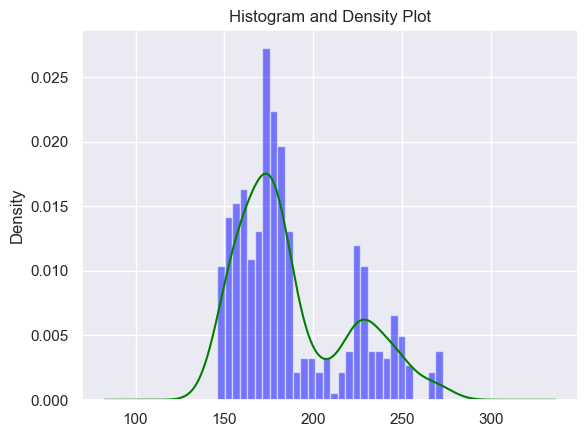

Skewness: 0.8894493399712174
Kurtosis: -0.30839684963948644
GMM Converged: True
GMM Weights: [0.72280776 0.27719224]


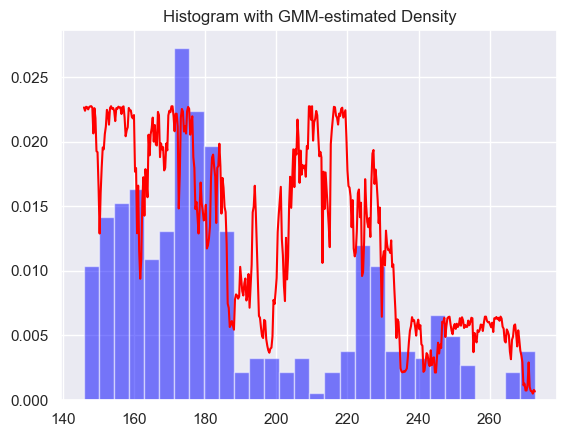

In [88]:

from scipy.stats import skew, kurtosis
from sklearn.mixture import GaussianMixture

# Visual Inspection
plt.hist(new_df['I-CIP'], bins=30, alpha=0.5, color='blue', density=True)
new_df['I-CIP'].plot(kind='density', color='green')
plt.title('Histogram and Density Plot')
plt.show()

# Check skewness and kurtosis
data_skewness = skew(new_df['I-CIP'])
data_kurtosis = kurtosis(new_df['I-CIP'])
print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

# Fitting a Gaussian Mixture Model >>> cant fit this model when there are Nan values in the datatset
gmm = GaussianMixture(n_components=2, random_state=0).fit(np.expand_dims(new_df['I-CIP'], 1))
gmm_scores = gmm.score_samples(np.expand_dims(new_df['I-CIP'], 1))

print(f"GMM Converged: {gmm.converged_}") # Check if the algorithm has converged
print(f"GMM Weights: {gmm.weights_}") # Gives the weights of the two components

# Plotting the GMM results
plt.hist(new_df['I-CIP'], bins=30, alpha=0.5, color='blue', density=True)
plt.plot(np.linspace(min(new_df['I-CIP']), max(new_df['I-CIP']), len(gmm_scores)), np.exp(gmm_scores), color='red')
plt.title('Histogram with GMM-estimated Density')
plt.show()

#Source: https://builtin.com/articles/gaussian-mixture-model


**ValueError: Input X contains NaN.** 
GaussianMixture does not accept missing values encoded as NaN natively.

### Weighted average


ICO Composite Indicator Price (I-CIP) is calculated using a weighted average of four coffee groups: Colombian Milds, Other Milds, Brazilian Naturals, and Robustas, with each group contributing a specific weight to the calculation:

- Colombian Milds: 12%
- Other Milds: 21%
- Brazilian Naturals: 30%
- Robustas: 37%


In [91]:
#print(new_df.info())

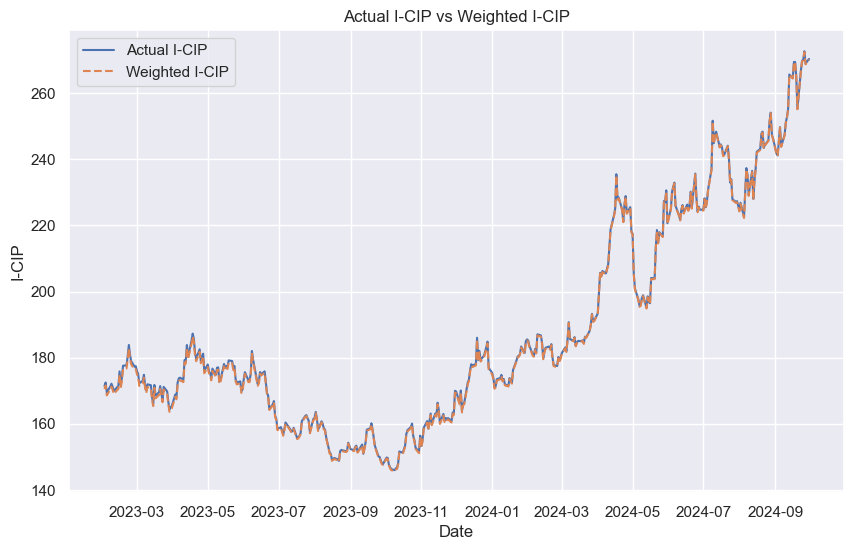

In [92]:
# Calculate the weighted I-CIP
new_df['weighted_I-CIP'] = (0.12 * new_df['colombian_milds'] +
                                 0.21 * new_df['other_milds'] +
                                 0.30 * new_df['brazilian_nat'] +
                                 0.37 * new_df['robustas'])

# Compare weighted I-CIP with actual I-CIP
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, copy_interpolated['I-CIP'], label='Actual I-CIP')
plt.plot(new_df.index, copy_interpolated['weighted_I-CIP'], label='Weighted I-CIP', linestyle='--')
plt.xlabel('Date')
plt.ylabel('I-CIP')
plt.title('Actual I-CIP vs Weighted I-CIP')
plt.legend()
plt.show()

#### Lag plots for I-CIP values
understanding the entropy of icip prices and how correlated they are

the scatter plot bellow shows the relationship between observations and their lags.
"as the lag increases, the correlation between the time series and its lags generally decreases."

Some sort of autocorrelation in the data is visible in lag 1, (t+1). A strong linear relationship indicates a high correlation between an observation and its immediate predecessor. a similar pattern is observed in lag2, with a few datapoints begining to get apart. Lags 3 and 4 are already more spreaded, meaning the correlation between values is also decreasing as the interval between lags grow.

<function matplotlib.pyplot.show(close=None, block=None)>

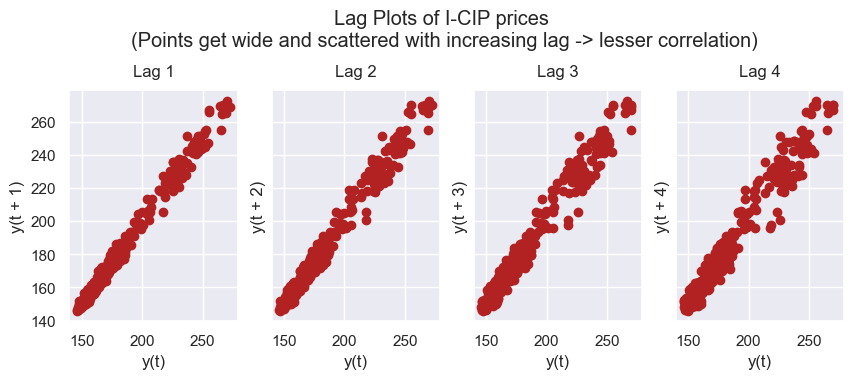

In [93]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

lp = new_df['I-CIP']

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(lp, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

    
fig.suptitle('Lag Plots of I-CIP prices \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

plt.show

In [ ]:
# Define the number of lags for 1 month
number_of_lags = 21

# Create subplots with 3 columns
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a lag plot for each lag
for i in range(1, number_of_lags + 1):
    lag_plot(icip_df['I-CIP'], lag=i, ax=axes[i-1])
    axes[i-1].set_title(f'Lag {i}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Rolling average / Rolling standard deviation


Rolling Mean: The rolling mean is the average of the previous observation window, where the window consists of a series of values from the time series data. Computing the mean for each ordered window. This can significantly help minimize noise in time series data.

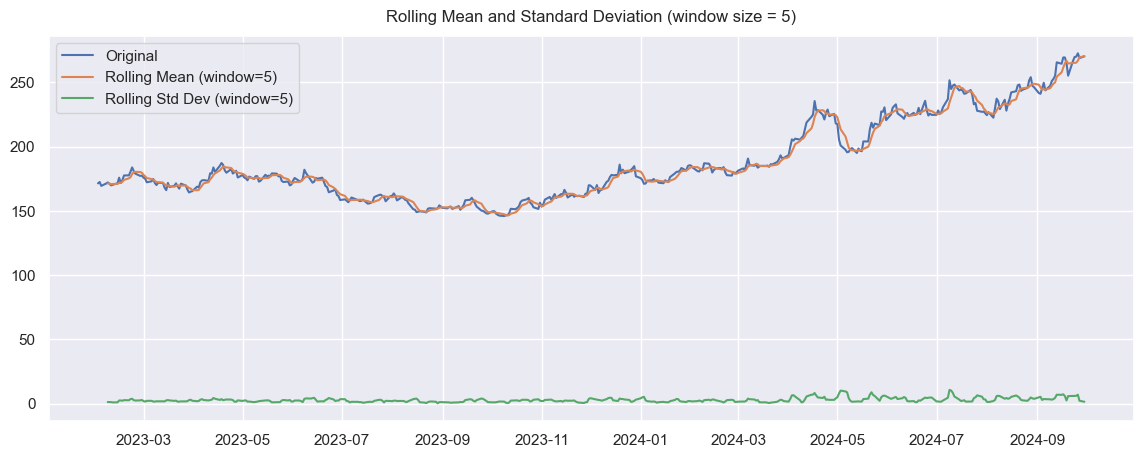

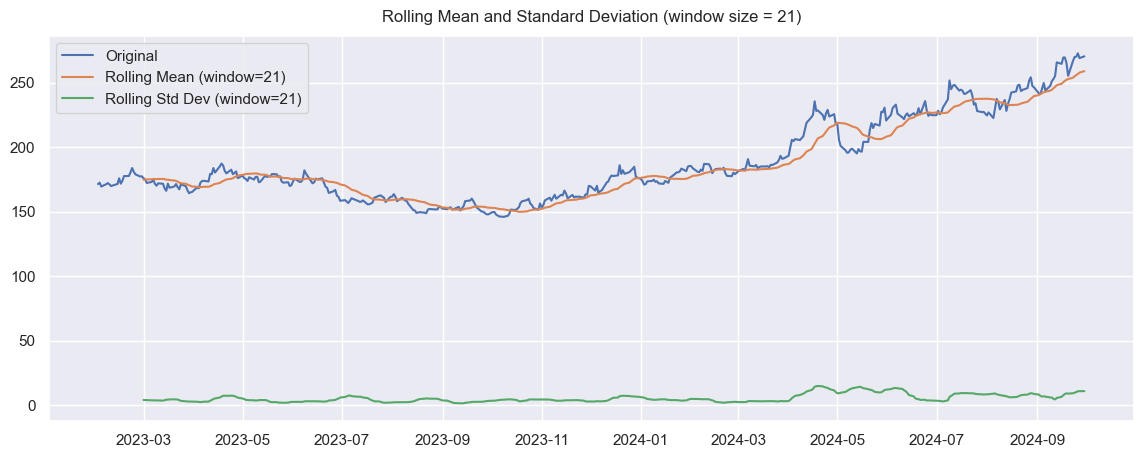

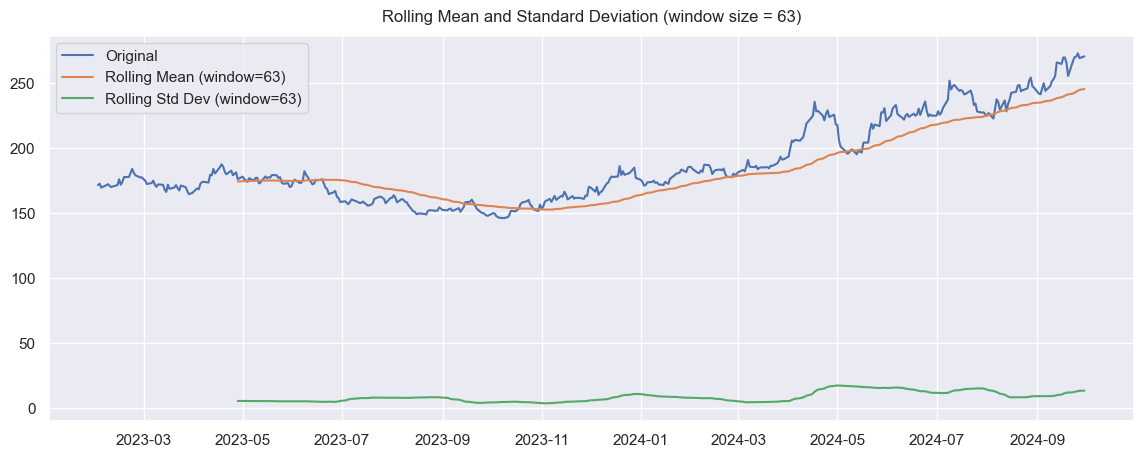

In [94]:
## Rolling Statistics at different periods
window_sizes = [5, 21, 63]  # A week, a month, a quarter,  (approximately)
data_rolling = new_df['I-CIP']  

for window in window_sizes:
    rolling_mean = new_df['I-CIP'].rolling(window=window).mean()
    rolling_std = new_df['I-CIP'].rolling(window=window).std()
    
    plt.figure(figsize=(14, 5))
    plt.plot(new_df['I-CIP'].index, new_df['I-CIP'], label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std.index, rolling_std, label=f'Rolling Std Dev (window={window})')
    plt.title(f'Rolling Mean and Standard Deviation (window size = {window})')
    plt.legend()
    plt.show()

In [95]:
# Function to print out results in customised manner
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# Call the function and run the test

kpss_test(new_df['I-CIP'])

Results of KPSS Test:
Test Statistic            2.483004
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
# Seasonal decompositions with different periods.

periods = [63, 21, 5]  # Quartely, Monthly and Weekly (considering business days)
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(copy_interpolated['I-CIP'], model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

# 3. Modelling